<font size="+3">CQF Exam Three (June 2022 Cohort))</font>

# Question 1

(a) Yes, there can exist an estimator with smaller MSE than minimal least squares, except it will be biased. Such an estimator would trade a little bias for a larger reduction in variance. The Gauss-Markov theorem implies that the least-squares estimator has the smallest mean square error of all linear estimators with no bias. (See Slide 17 of M4L4.)

(b) MSE represents model error; there still remains an irreducible error. Assume $Y = f(X) +\epsilon$ where $E(\epsilon)=0$ and $Var(\epsilon) = \sigma^2_{\epsilon}$. For a linear model fit $\hat{f}_p(x)=x^T\beta$ where the parameter vector $\beta$ with $p$ components is fit by least squares, we can write the expected prediction error of a regression fit $\hat{f}(X)$ at an input point $X=x_0$ as:
$$
Err(x_0) = E[(Y-\hat{f}(x_0))^2|X=x_0]
$$
$$
=\sigma^2_{\epsilon}+||{h(x_0)}||^2\sigma^2_{\epsilon}+[E\hat{f}_p(x_0)-f(x_0)]^2,
$$
where
$$
h(x_0) = X(X^TX)^{-1}x_0
$$
$$
\hat{f}_p(x_0) = x_0^T(X^TX)^{-1}X^Ty.
$$
The first term is the irreducible error, the second and third terms form the MSE in the way it is defined in the exam text. (See Section 7.3 of Reference 1.)

# Question 2

The correct answer is (a). Since $z_2$ is geometrically far away from $x$, its Euclidean distance $$||z_2-x||^2$$ is large and the exponential of a large negative number is close to zero (assuming $\sigma > 0$). The mirror argument holds for $z_1$. Note: that is the very point of kernel methods; that is: to use weights that decrease smoothly to zero with distance from the target point.

# Question 3

For decision (classification) trees, we can think of three loss functions:
$$
L(y,f(x)) = \exp(-yf(x)) \text{ (exponential loss)}
$$
$$
L(y,f(x)) = (y-f(x))^2 \text{ (squared-error loss)}
$$
$$
L(y,f(x)) = I(yf(x)\lt0) \text{ (missclassification loss)}.
$$

# Question 4

## Business setting

In this work, we focus on ICE Brent crude oil futures, specifically the daily front-month unadjusted continuation series LCOc1 from 2011-present. The series is unadjusted in the sense that there could be gaps introduced by the rolls at expiry. Building a rolls-adjusted continuation futures series is beyond the scope of this work, and we refer to section 2.4.3 of Reference 2 for a way to do that. We are aware that the rolls gaps may introduce some fictitious positive or negative returns not observed in real life, but we accept this assumption in this work. 

In addition to the usual technical indicators (momentum, volatility...), our model features will include domain-specific quantities such as:
- Money managers long/short ratio and open interest (reported by the CFTC), 
- The week-on-week change of the money managers long/short ratio and open interest,
- The U.S. total crude oil in storage (reported by the EIA).

Those are trailing weekly numbers, resampled to daily values.

Brent is a highly liquid instrument, used for both physical trading and speculative hedging. It is currently experiencing a bullish supercycle like most commodities, although there are volatility clusters (covid-19 pandemic, Russia/Ukraine conflict) and a recent downtrend.

## Mathematical setting

### Support Vector Classifier

Given training data consisting of $N$ pairs $(x_1, y_1), ..., (x_N, y_N)$ with $x_i \in R^p$ and $y_i \in \{-1,1\}$, the SVC finds linear boundaries in the input feature space and can be expressed as a quadratic program:
$$
\text{min}_{w, w_0} \frac{1}{2}||w||^2+C\sum_{i=1}^{N}\chi_i
$$
$$
\text{s.t.} \chi_i \gt 0, y_i(x_i^Tw+w_0)\gt 1-\chi_i, \forall i.
$$
where $C$ is a "cost" hyperparameter and $\chi_i$ are slack variables. It can be seen that when $\chi_i$ is nonzero, $x_i$ is not correctly classified (it can be inside the margin, on the hyperplane, or on the wrong side of the hyperplane); thus higher values of $C$ focus attention more on correctly classified points near the decision boundary, while smaller values involve data further away. We will tune $C$ in a subsequent section.

### Support Vector Machines

When the training data is not linearly separable, the SVC may struggle to achieve training-class separation. SVMs aim to enlarge the feature space using basis expansions in order to achieve better training-class separation. This translates to nonlinear boundaries in the original space. 

Following Section 12.2.1 of Reference 1, we write the Lagrange (dual) objective for the SVM:
$$
L_D(\alpha) = \sum_{i=1}^{N}\alpha_i-\frac{1}{2}\sum_{i=1}^{N}\sum_{i'=1}^{N}\alpha_i\alpha_{i'}y_iy_{i'}<h(x_i),h(x_{i'})>
$$
where 
$$
<h(x),h(x')> = K(x, x')
$$
and other constraints must hold (refer to Section 12.2.1 of Reference 1 for a full specification); several kernel choices are available:
$$
K(x, x') = (1+<x,x'>)^d \text{ polynomial},
$$
$$
K(x, x') = tanh(\kappa_1<x,x'>+\kappa_2) \text{ neural network},
$$
$$
K(x, x') = exp(-\gamma||x-x'||^2)\text{ radial basis}.
$$

The hyperparameter $\gamma$ is the scale of the radial basis kernel. $C$ and $\gamma$ interact with each other on classification error; Figure 12.6 of Reference 2 suggests that error is minimized for large $C$ and small $\gamma$ (although this is data-specific and we will address this in the hyperparameter tuning step below).

## Methodology

The 7 steps to model-building referred to in the exam text are:
<ol>    
    <li> Retrieve data </li>
    <li> Specify features </li>
    <li> Define labels </li>
    <li> Split data into train and test subsets</li>
    <li> Fit model</li>
    <li> Predict model, present prediction score, plot confusion matrix</li>
    <li> Tune hyperparameters, predict refitted model, present the trading strategy.</li>
</ol>    

In this work, we will follow broadly this methodology but go through two stages:
<ol>    
    <li> Stage A: among a wide range of candidates, search for labeling methods that provide high classification accuracy and financial return,</li>
    <li> Stage B: withing a narrower set of candidates identified from Stage A, identify the labeling method that provides highest classification accuracy and financial return and tune its hyperparameters.</li>
</ol>

## Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import datetime 
%matplotlib inline

pricespath = "C:\\Users\\Julien.Granger\\PycharmProjects\\test\\data\\prices\\"

from datetime import date
today = date.today().strftime('%Y-%m-%d')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation 
import missingno

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

# Preprocessing & Cross validation
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score

# Dimensionality reduction
from sklearn.decomposition import KernelPCA, PCA

# SVC
from sklearn.svm import SVC

# XGBoost Classifier
from xgboost import XGBClassifier, plot_importance, to_graphviz

# Metrics
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_curve, auc

# For checking mean-reversion
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Graphics
import cufflinks as cf
cf.set_config_file(offline=True)

#MLfLow
import mlflow
import mlflow.sklearn

## Read input file

We load data from an Excel file containing daily open, high, low, close and volume data originally downloaded from Eikon. Technical indicators were computed using the TA library, including (please refer to Reference 4 for a definition of these): 
<ol>
    <li>RSI,
     <li>ROC, 
         <li>ADX,
             <li>BBM,
                     <li>MACD. 

We make sure to shift technical indicators backwards by one day and to not use today's close to compute these, otherwise we would be leaking data, a major "sin" of using machine learning in finance (see Chapter 11 of Reference 2). Fundamental and market positioning indicators are merged to the datatest. This preliminary work is done in a separate file and not detailed here.

In [2]:
# Read HO with technical indicators, fundamental indicators and market positioning,
# previously loaded from Eikon
df = pd.read_excel(pricespath+"LCOc1_all_light.xlsx", parse_dates= True)
df.set_index('Date', inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLOSE,2891.0,7.570035e+01,26.340221,19.330000,5.392500e+01,6.887000e+01,1.055900e+02,1.279800e+02
VOLUME,2891.0,2.273484e+05,95038.612893,5892.000000,1.746350e+05,2.276770e+05,2.846470e+05,7.797230e+05
rsi_14,2891.0,5.052734e+01,12.982427,12.612454,4.257726e+01,5.139433e+01,5.976979e+01,8.529982e+01
roc_5,2891.0,1.180544e-01,5.322886,-34.695946,-2.272254e+00,1.842978e-01,2.511858e+00,5.136852e+01
roc_20,2891.0,4.435074e-01,10.409279,-57.916103,-5.203726e+00,8.760723e-01,5.927987e+00,7.925504e+01
roc_50,2891.0,1.270109e+00,17.441760,-65.125611,-7.061527e+00,8.444692e-01,1.084654e+01,1.156078e+02
bbm,2891.0,7.575458e+01,26.261009,25.694000,5.367825e+01,6.841500e+01,1.067562e+02,1.247355e+02
bbw,2891.0,1.354378e+01,10.873566,2.042073,7.325530e+00,1.116659e+01,1.608638e+01,1.090418e+02
macd,2891.0,-4.796089e-02,1.715817,-7.801412,-8.731452e-01,1.445488e-01,1.047981e+00,8.233340e+00
adx_pos,2891.0,2.050120e+01,6.948858,2.489132,1.573265e+01,2.061868e+01,2.505660e+01,4.842041e+01


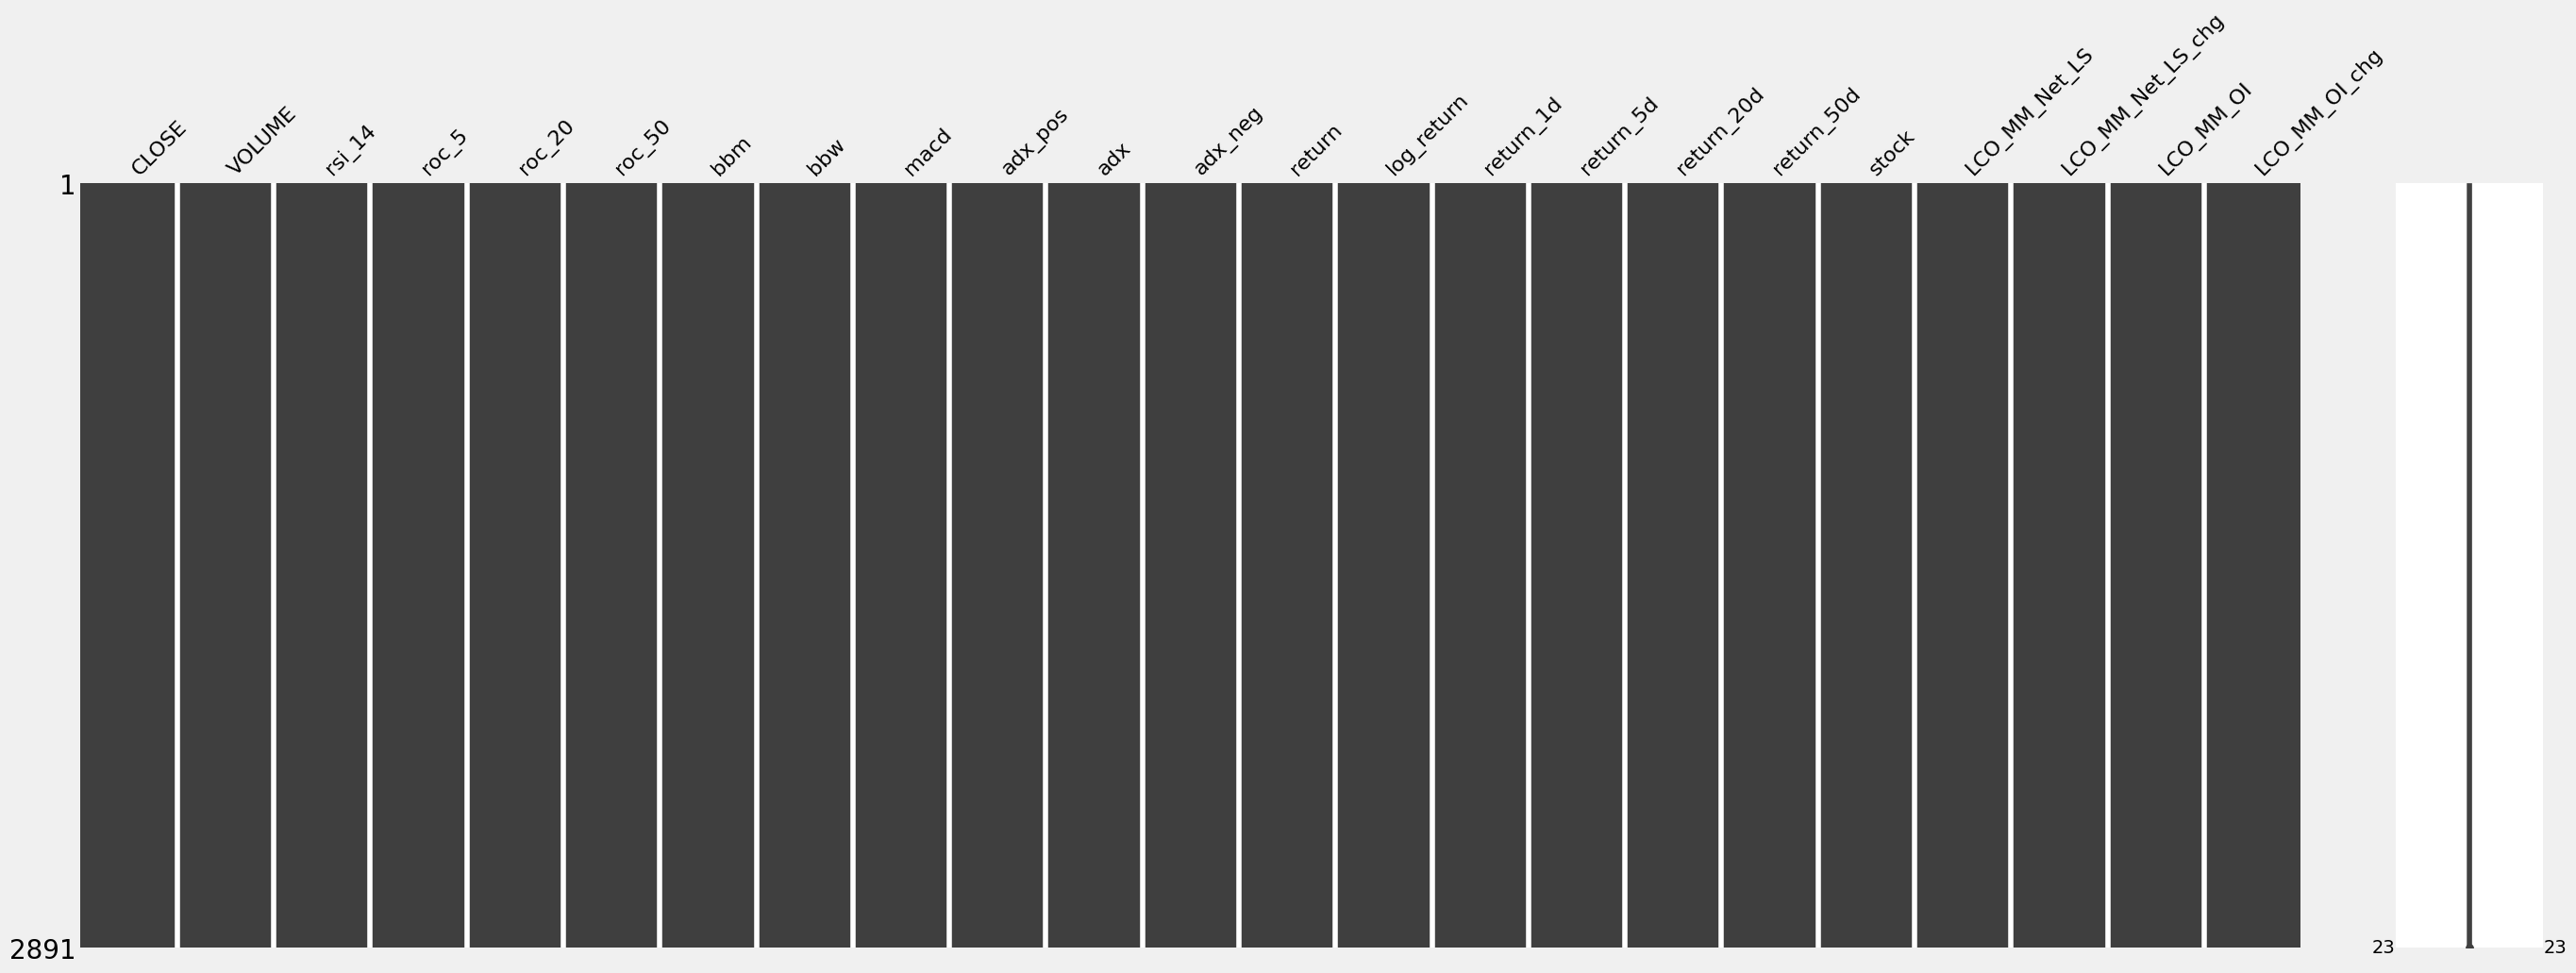

In [3]:
# Use missingno library to verify missing values
missingno.matrix(df, sparkline=True, figsize=(30,10));

## Analysis of price and returns

### Price

<AxesSubplot: xlabel='Date'>

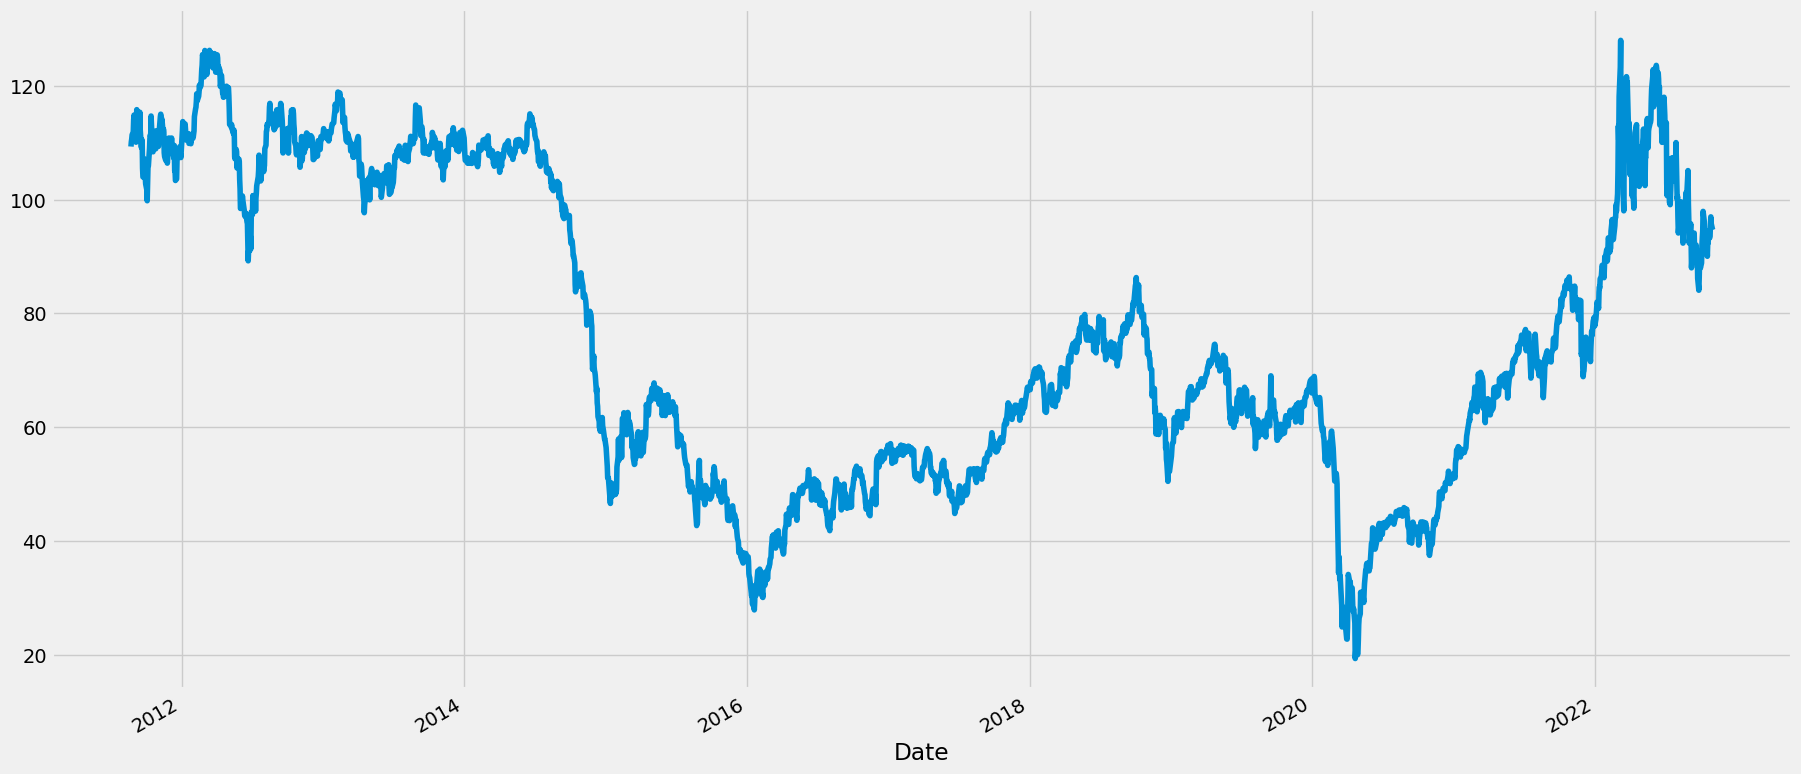

In [4]:
df.CLOSE.plot()

<AxesSubplot: xlabel='Date'>

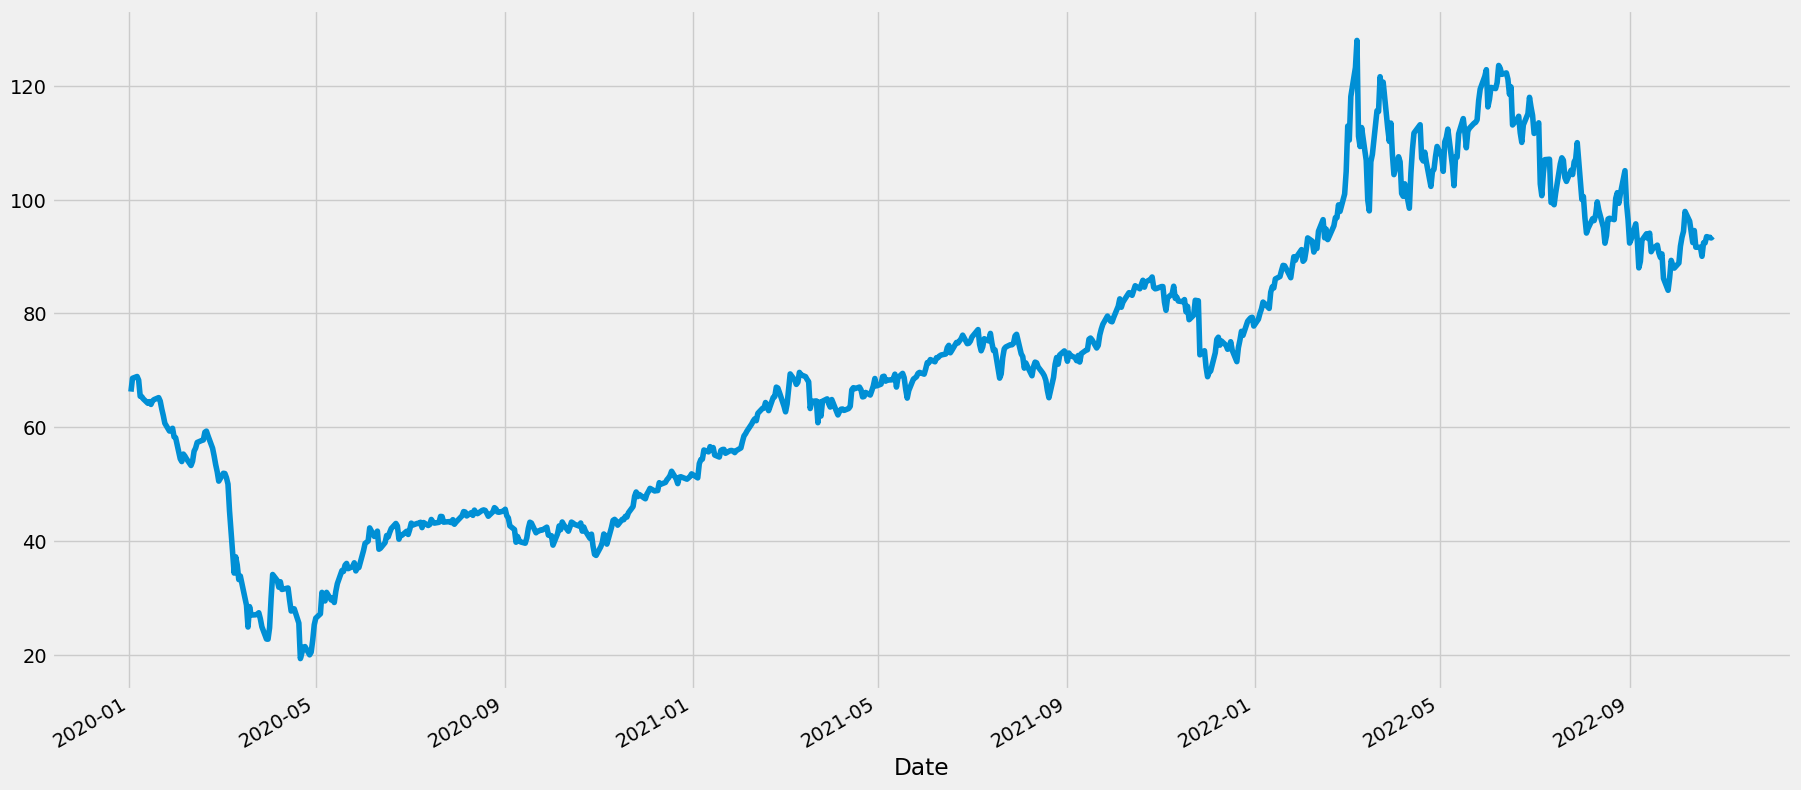

In [5]:
df['2020-01-01':'2022-10-25']['CLOSE'].plot()

Observation: the daily close prices series hovers between about \\$50 and \\$80 per bbl between 2015 and early 2020 until it collapses during the covid-19 pandemic. It has recovered since although it has experienced strong volatility clusters (Russia/Ukraine conflict) and a downtrend since June 2022, which will be interesting since it will contain our testing period and we are looking to classify up moves.

### Returns

In [6]:
# Stationarity test 
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
adf_test(df['return'])

Results of Dickey-Fuller Test:
Test Statistic                -9.899765e+00
p-value                        3.382222e-17
#Lags Used                     2.200000e+01
Number of Observations Used    2.868000e+03
Critical Value (1%)           -3.432632e+00
Critical Value (5%)           -2.862548e+00
Critical Value (10%)          -2.567307e+00
dtype: float64


In [8]:
adf_test(df['log_return'])

Results of Dickey-Fuller Test:
Test Statistic                -9.880604e+00
p-value                        3.779024e-17
#Lags Used                     2.200000e+01
Number of Observations Used    2.868000e+03
Critical Value (1%)           -3.432632e+00
Critical Value (5%)           -2.862548e+00
Critical Value (10%)          -2.567307e+00
dtype: float64


Observation: For the entire horizon, the test statistic is more negative than the critical value at 1% (which is about -3.43) and therefore the returns and log-returns series are deemed stationary. With this in mind we will define our labels using information pertaining to the entire dataset (the quantiles) and not just to the training dataset. Strictly speaking this labelling approach suffers from data leakage; however because we have established that the return series is stationary we accept this approach as workable in practice.

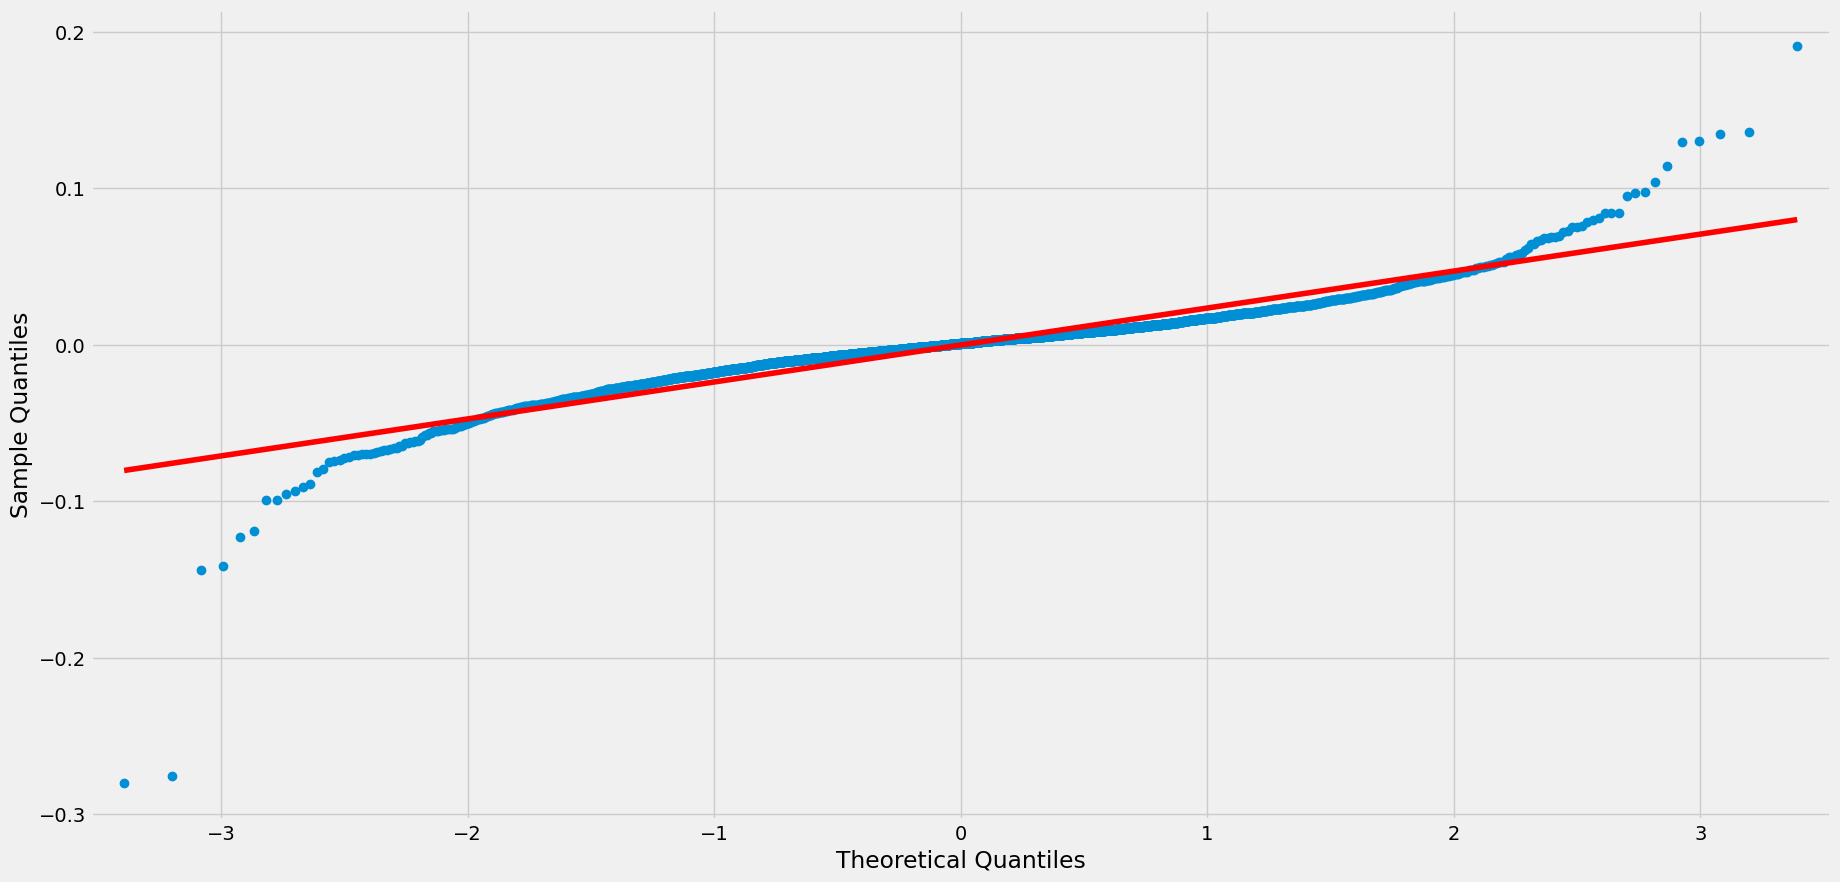

In [9]:
sm.qqplot(df['log_return'], line = 's');

Observation: The q-q plot shows the log-returns have fat tails; the goal of the classification algorithm will be to identify the positive fat tails and place a bet when found.

## Analysis of some selected features

<AxesSubplot: xlabel='Date'>

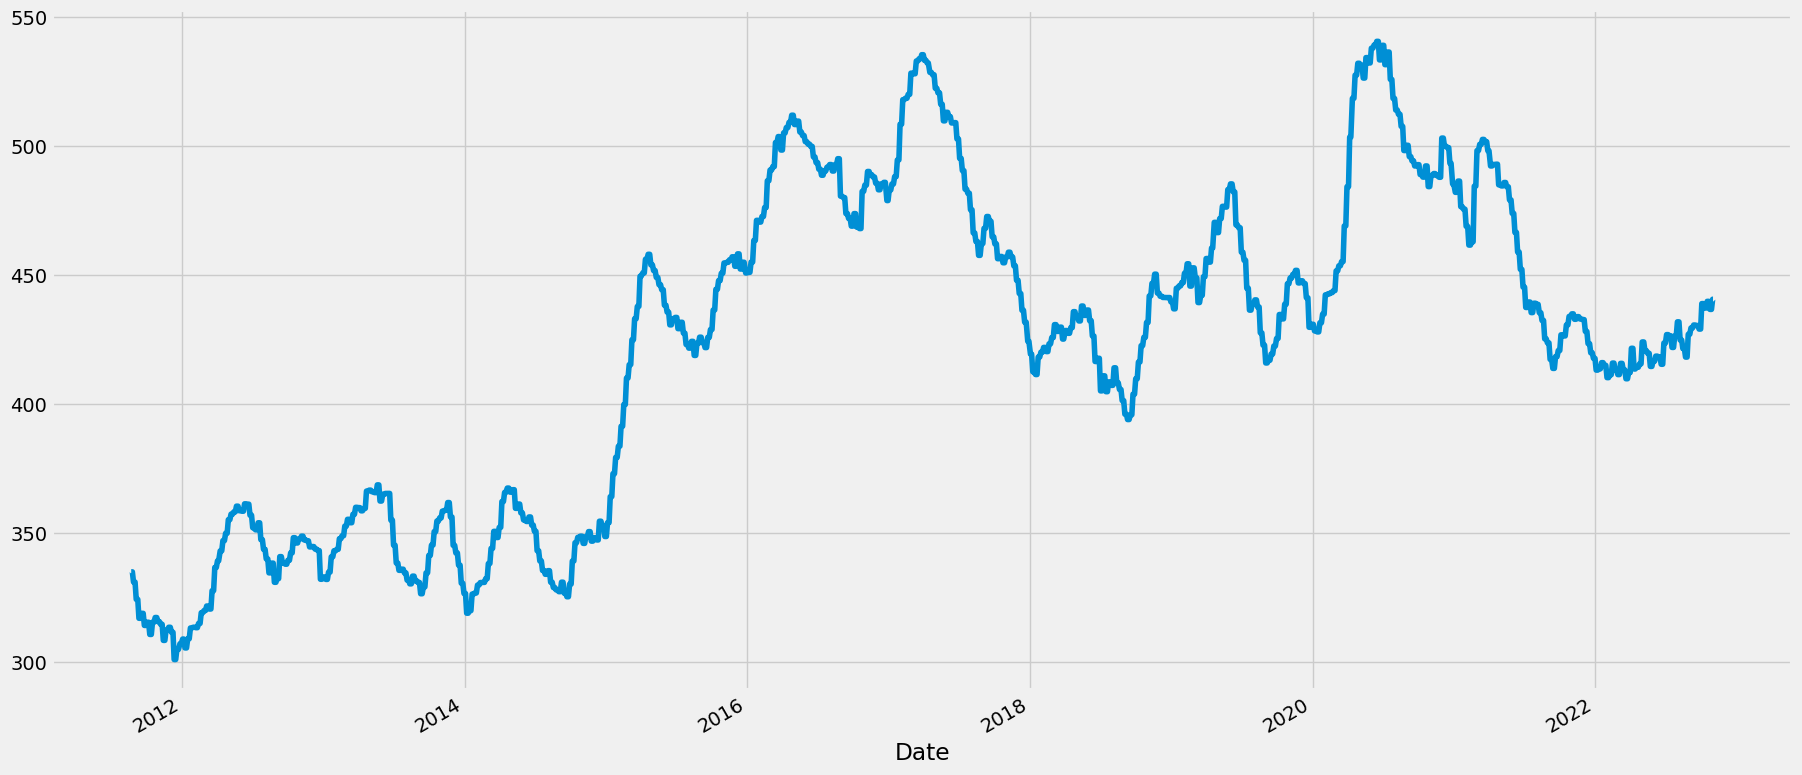

In [10]:
df.stock.plot()

Observation: total U.S. crude oil inventories appeares near the middle of the range prior to the covid-19 pandemic, after which they shot up to a high range. They have returned to the bottom of the range since then.

## Feature correlation

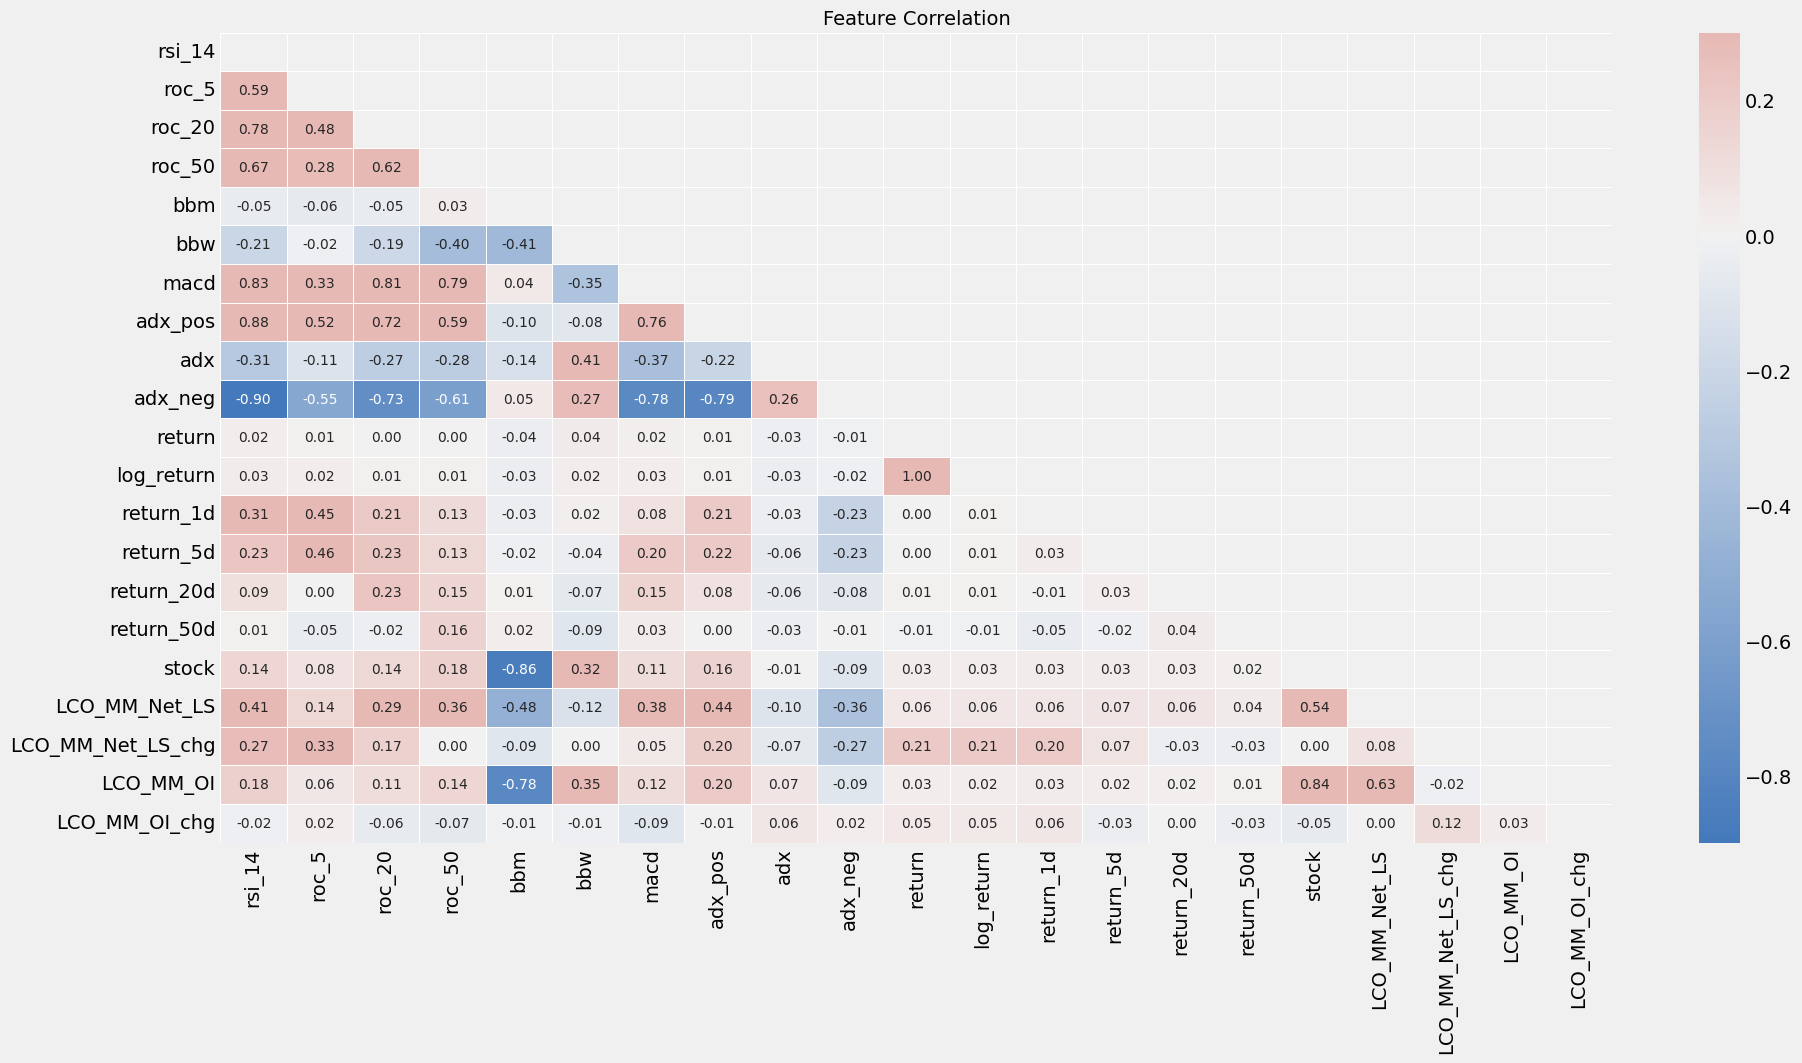

In [11]:
# Derive features correlation
corrmat = df.drop(['CLOSE','VOLUME'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, 
            fmt="0.2f", mask=mask, cmap = cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": 1})

ax.set_title('Feature Correlation', fontsize=14, color='black');

Observation: several features are heavily correlated, such as: 
<ol>
    <li>crude stocks ("stock") are negatively correlated to the Bollinger band mean ("bbm"), 
    <li>the Bollinger band meand and the money manager open interest ("LCO_MM_OI") are negatively correlated,
    <li>the minus Directional Indicator ("ADX_neg") is negatively correlated to the Relative Strength Index, etc.

We do not explicitly drop correlated features but instead rely on a principal component analysis to reduce the dimension of the input dataset later on.

## Add extra features

In [12]:
# Return sign
df['return_sign'] = np.sign(df['return'].values)
df['return_sign_1d'] = df['return_sign'].shift(+1)

In [13]:
df.dropna(inplace = True)

## Final feature set

In [14]:
# Convert to NumPy
X = df.drop(['CLOSE','VOLUME', 'return', 'log_return','return_sign'],axis=1)

In [15]:
X.shape

(2890, 20)

## Target definition

### Returns

Within our methodology, the size of the returns we are looking to classify is a design parameter. Looking below, the mean return is 0.02% and half of the returns are above 0.09%. Let $\tau >0$ be a real number. Per exam text, we are constrained to have two classes:
$$
\text{Class 1: } r_t \gt \tau, \text { which will include all the up trend moves,}
$$
$$
\text{Class 0: } r_t \lt \tau, \text { which will include all moves smaller than } \tau \text{, including down trend moves}.
$$


In [16]:
100*np.quantile(df['return'], q = 0.5)

0.09462926746566236

In [17]:
100*df['return'].mean()

0.022735274648815047

<AxesSubplot: >

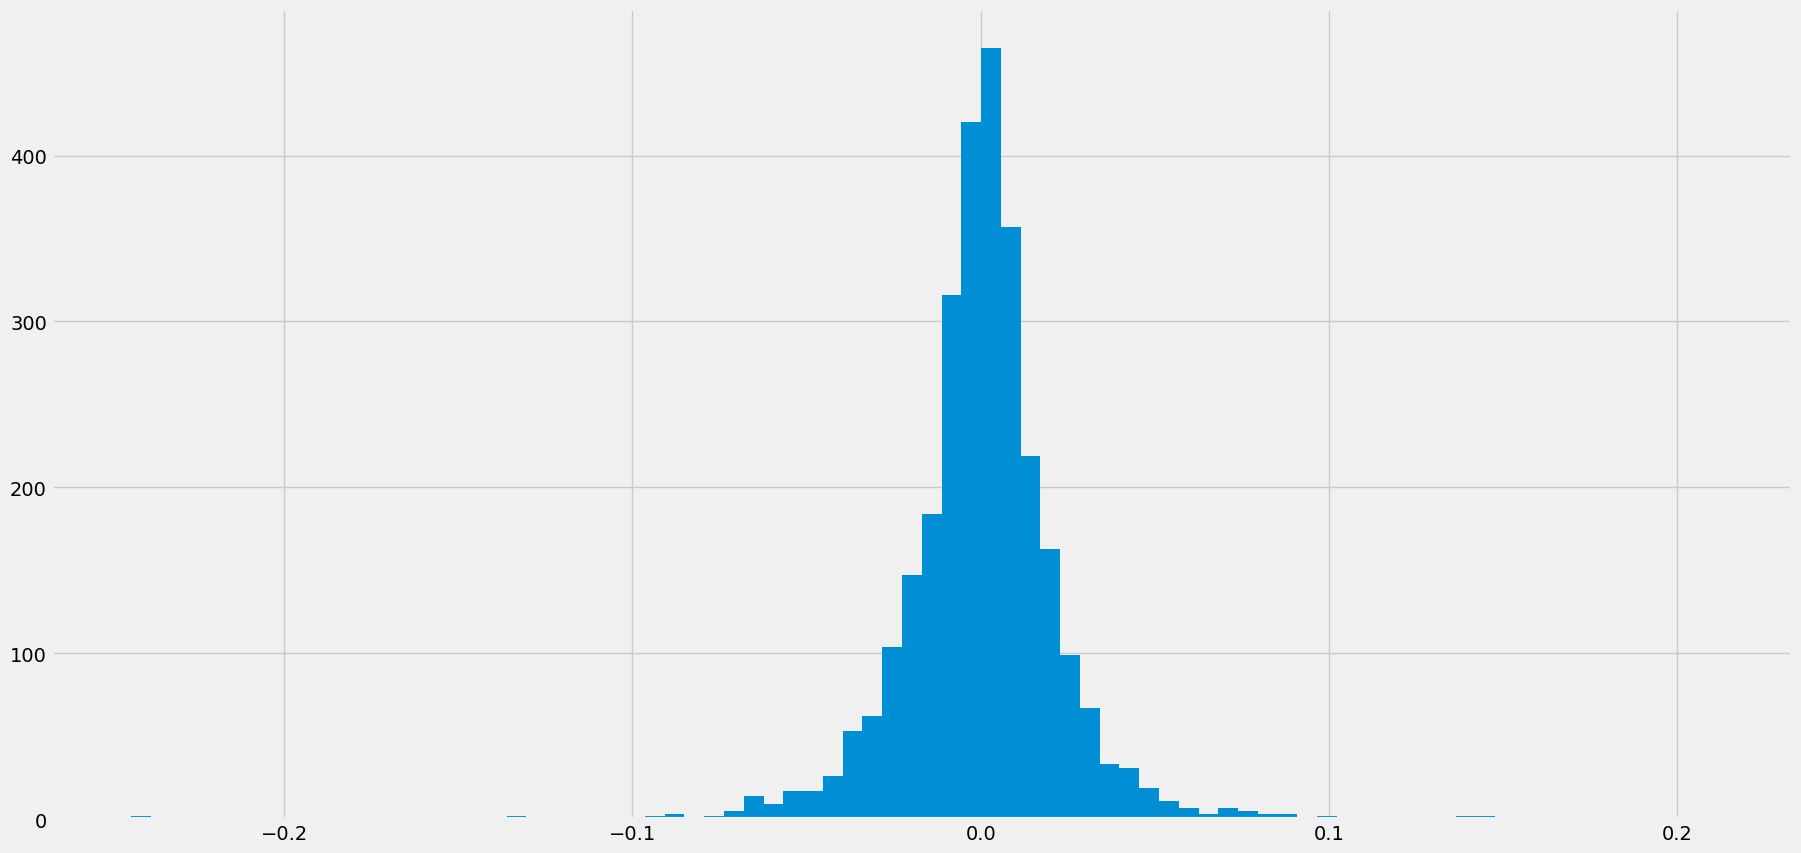

In [18]:
df['return'].hist(bins =80)

### Metrics

There are various performance metrics to consider:
<ol>    
    <li> Precision: predicted positives divided by all positive predictions (TP/(TP+FP)). Note going long on a FP could be a cause of ruin if the FP is a large negative move.  </li>
    <li> Recall: percentage of actual positives that were correctly classified (TP/(TP+FN)). Note that not investing on a FN is not necessarily a cause of ruin but more like a missed opportunity and may simply depress our overall strategy cumulative profit. </li>
    <li> F1 score (2xprecisionxrecall/(precision+recall)), an attempt to balance precision and recall, which we will use in our hyperparameter tuning. </li>
    <li>ROC curve: a curve of TP rate vs. FP rate at different classification thresholds; a good model produces a curve that goes quickly from 0 to 1. The AUC summarizes the ROC with a single number. Fomr a classification viewpoint, our best model will be the one with highest AUC.</li>
    <li> Overall strategy financial metrics (such as Sharpe ratio) which may be superior for a strategy even if it has a lower AUC. Ultimately we care about making money. From a a financial viewpoint, our best model will be the one with highest Sharpe ratio (although in practice one would need to balance Sharpe ratio, profit to max drawdown, and other metrics, please refer to Section 14.4 of Reference 2).</li>
</ol>.

### Strategies

The exam text restricts us to classify positive moves (up trends) only, which we interpret to be returns above a predetermined threshold $\tau \gt 0$. However, the exam text leaves us free to choose our investement strategy. We can come up with two investement strategies:

<ol>    
    <li> Long-only (LO): If return is predicted to be in Class 1, go long; otherwise don't invest.
    <li> Long-short (LS): If return is predicted to be in Class 1, go long; if return is predicted to be in Class 0, go long or short based on the sign of yesterday's return. The rationale is that empirical data show that returns within trends are serially correlated. This strategy will allow us to catch both uptrends and downtrends while still only classifying uptrends. 
       


We will test whether one type of investment strategy dominates the other in this classification setting.

### Split dateset

We create targets, find class weights and split the dataset below, althouth these will change in the next section. We will address class imbalance through the "class_weight" parameter of the SVC classifier; we leave other approaches (e.g. over/undersampling via the imbalanced-learn library) to future research.

In [19]:
# Quantile threshold
tau = 0.6

In [20]:
# Define label or target 
y = np.where(df['return'] >= np.quantile(df['return'], q = tau), 1, 0)

In [21]:
# Looking to classify returns above
100*np.quantile(df['return'], q = tau)

0.4446325810301043

In [22]:
# Check class imbalance
pd.Series(y).value_counts()

0    1734
1    1156
dtype: int64

In [23]:
# Create class weights to rebalance classes
class_0, class_1 = np.bincount(y)
w_0 = 0.5*(1/class_0)*len(y)
w_1 = 0.5*(1/class_1)*len(y)
print(w_0, w_1)
class_weights = {0: w_0, 1: w_1}

0.8333333333333334 1.25


In [24]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Phase A: Exploration

### Define base pipeline

SVMs are distance-based algorithms and therefore sensitive to outliers; following Reference 5 our pipeline will thus start with a Min-Max scaler. It will then include a principal component analysis for dimensionality reduction as SVMs are known to perform better with fewer features (we leave the choice of dimensionality as automatic via Minka's algorithm, see Reference 6). Our last step will be the classifier. We will not use an imputer as we do not have missing data.

In [25]:
pipe = Pipeline([("scaler", MinMaxScaler()), 
                 ("pca", PCA(random_state=37,
                            n_components = 'mle',
                            svd_solver = 'full')),
                 ("classifier", SVC(kernel='rbf',
                                    C=10,
                                    gamma=0.1,
                                    probability = True,
                                    class_weight = class_weights
                                   ))
                ]) 
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca',
                 PCA(n_components='mle', random_state=37, svd_solver='full')),
                ('classifier',
                 SVC(C=10, class_weight={0: 0.8333333333333334, 1: 1.25},
                     gamma=0.1, probability=True))])

### Main loop of the base models

We start the iteration at $\tau = 0.525$ because those are returns that are above 0.17%, which is a value slightly below the threshold of 0.25% recommended by the exam text to define meaningful positive returns.

In [26]:
# Create dataframe to store results
df1 = df[-len(y_test):]

In [27]:
#Long/Short Strategies
to_plot_LS = ['log_return']
Sharpe_LS = []

#Long-only Strategies
to_plot_LO = ['log_return']
Sharpe_LO = []

model_num = 0

arr_LS = np.empty([9,2], dtype = float)
arr_LO = np.empty([9,2], dtype = float)

for tau in [0.525, 0.535, 0.545, 0.55, 0.575, 0.6, 0.7, 0.8, 0.9]:
    model_num +=1
    print('model number: ', model_num)
    print('tau is: ', tau)
    min_ret = 100*np.quantile((df['return']), q = tau)
    
    y = np.where( (df['return'] >= np.quantile(df['return'], q = tau))  
                   , 1, 0)
                 
    print('Looking for returns above (%): ', 100*np.quantile((df['return']), q = tau))
    mlflow.log_metric("Class_1_min_ret_perc", 100*np.quantile((df['return']), q = tau))
    
    print(pd.Series(y).value_counts())
    class_0, class_1 = np.bincount(y)
    w_0 = 0.5*(1/class_0)*len(y)
    w_1 = 0.5*(1/class_1)*len(y)
    print("Class weights: ", w_0, w_1)
    class_weights = {0: w_0, 1: w_1}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    pipe = Pipeline([("scaler", MinMaxScaler()), 
                 ("pca", PCA(random_state = 12,
                            n_components = 'mle',
                            svd_solver = 'full')),
                 ("classifier", SVC(kernel ='rbf',
                                    C = 10,
                                    gamma = 0.1,
                                    probability = True,
                                    class_weight = class_weights
                                   ))
                ])  
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    
    print(f'Train Accuracy (%): {pipe.score(X_train,y_train):0.4}')
    print(f'Test Accuracy (%): {pipe.score(X_test,y_test):0.4}')
    probs = pipe.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print(f'AUC: {roc_auc:0.4}')
    mlflow.log_metric("ROC_AUC", roc_auc)
    arr_LS[model_num-1][0] = roc_auc
    arr_LO[model_num-1][0] = roc_auc
    
    mlflow.log_metric("Train_accuracy", pipe.score(X_train,y_train))
    mlflow.log_metric("Test_accuracy", pipe.score(X_test,y_test))
    mlflow.sklearn.log_model(pipe, "model")
    
    str1 = ('min_ret_%.3f' % min_ret)
    str2 = ('_mod_#_%.1f' % model_num)
    mod_name = str1+str2
    label_LS = 'L-S_'+mod_name
    df1[label_LS] = df1['log_return'] * y_pred + df1['log_return'] * (1-y_pred) * df1['return_sign_1d']
    to_plot_LS.append(label_LS)
    label_LS_sharpe = label_LS+'_Sharpe'   
    sharpe  = (252**0.5) * df1[label_LS].mean() / df1[label_LS].std()
    arr_LS[model_num-1][1] = sharpe 
    print("Sharpe: ", (252**0.5) * df1[label_LS].mean() / df1[label_LS].std())
    
    label_LO = 'LO_'+mod_name
    df1[label_LO] = df1['log_return'] * y_pred 
    to_plot_LO.append(label_LO)    
    label_LO_sharpe = label_LO+'_Sharpe'    
    sharpe = (252**0.5) * df1[label_LO].mean() / df1[label_LO].std()
    arr_LO[model_num-1][1] = sharpe 

    print('----------------')

model number:  1
tau is:  0.525
Looking for returns above (%):  0.17834915194164758
0    1517
1    1373
dtype: int64
Class weights:  0.9525379037574159 1.0524399126001458
Train Accuracy (%): 0.622
Test Accuracy (%): 0.545
AUC: 0.6159
Sharpe:  1.3918684707055882
----------------
model number:  2
tau is:  0.535
Looking for returns above (%):  0.22478124242179906
0    1546
1    1344
dtype: int64
Class weights:  0.9346701164294956 1.0751488095238095
Train Accuracy (%): 0.6237
Test Accuracy (%): 0.5536
AUC: 0.6118
Sharpe:  1.4097810649598497
----------------
model number:  3
tau is:  0.545
Looking for returns above (%):  0.2684968265236314
0    1575
1    1315
dtype: int64
Class weights:  0.9174603174603174 1.0988593155893536
Train Accuracy (%): 0.6241
Test Accuracy (%): 0.5554
AUC: 0.6081
Sharpe:  1.6641991813811785
----------------
model number:  4
tau is:  0.55
Looking for returns above (%):  0.2846496979809742
0    1589
1    1301
dtype: int64
Class weights:  0.9093769666456891 1.11068408

In [28]:
# AUC and Sharpe ratios of LS and LO strategies for models of Stage A
results = pd.DataFrame({'ROC_AUC': arr_LS[:,0], 'Sharpe_LS': arr_LS[:,1], 'Sharpe_LO': arr_LO[:,1]})
results.index = range(1,len(results)+1)
results.index.rename('mod_num', inplace = True)
results.tail(10)

,ROC_AUC,Sharpe_LS,Sharpe_LO
mod_num,,,
1,0.615897,1.391868,2.900472
2,0.611782,1.409781,2.919336
3,0.608057,1.664199,3.097142
4,0.610276,1.607895,3.167301
5,0.603065,1.801552,3.365362
6,0.593477,1.803835,3.288678
7,0.582963,1.348928,3.037488
8,0.570178,0.863943,2.585626
9,0.532926,0.334659,1.888666


### Scenario results of Long-short strategy

<AxesSubplot: xlabel='Date'>

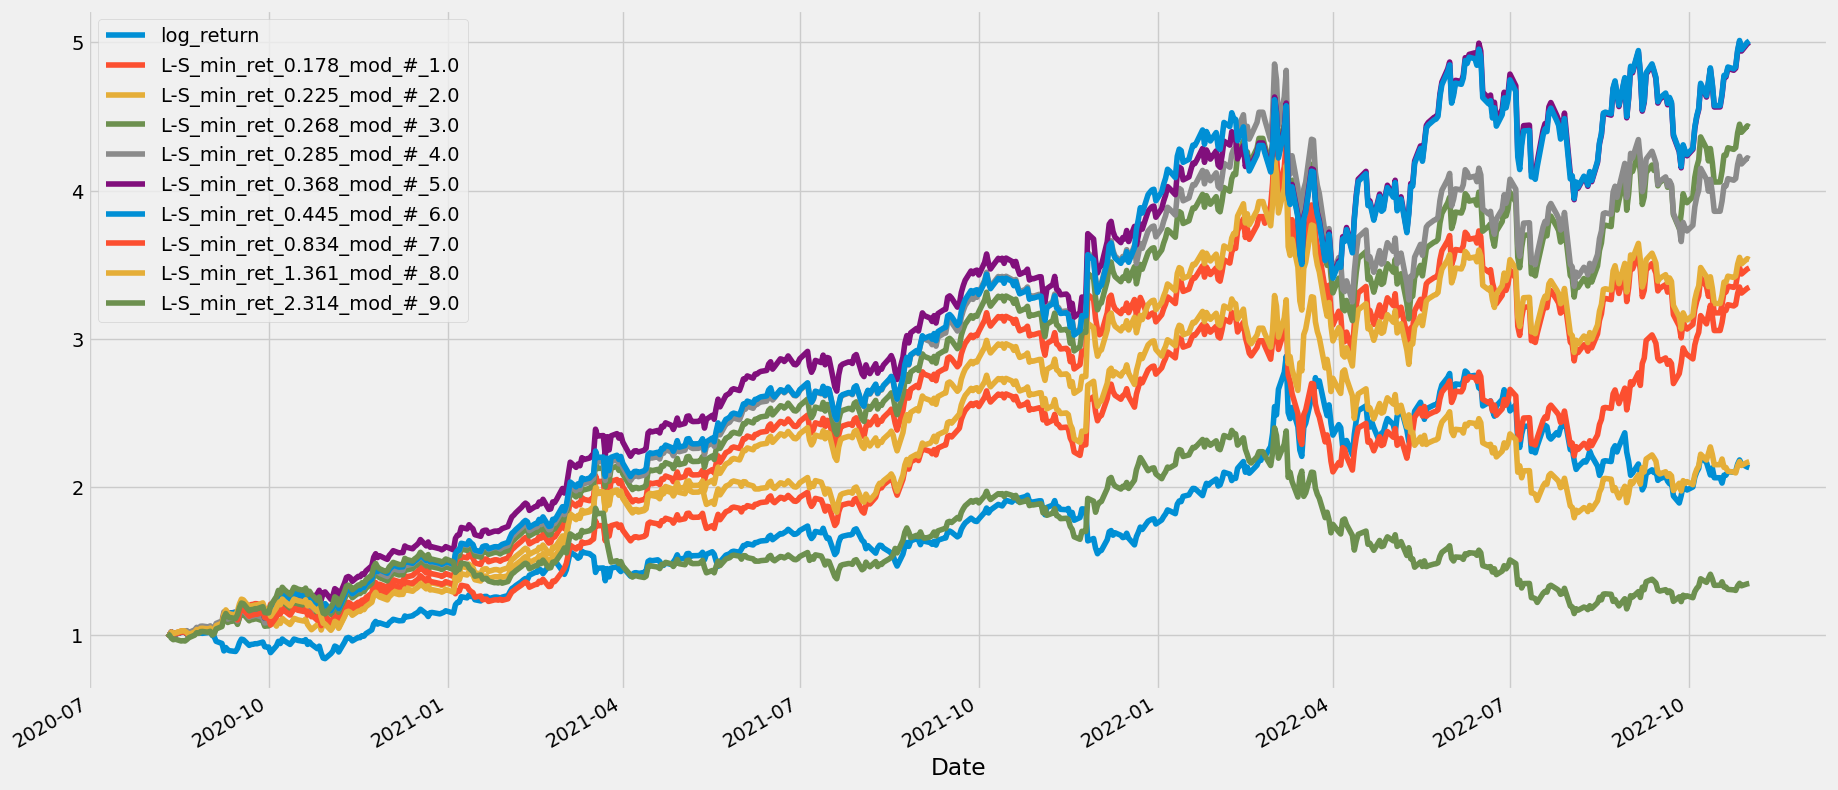

In [29]:
df1[to_plot_LS].cumsum().apply(np.exp).plot()

In [30]:
# Final return
df1[to_plot_LS].cumsum().apply(np.exp).tail(1).T

Date,2022-11-01
log_return,2.131757
L-S_min_ret_0.178_mod_#_1.0,3.478266
L-S_min_ret_0.225_mod_#_2.0,3.534073
L-S_min_ret_0.268_mod_#_3.0,4.428177
L-S_min_ret_0.285_mod_#_4.0,4.212966
L-S_min_ret_0.368_mod_#_5.0,4.999271
L-S_min_ret_0.445_mod_#_6.0,5.009345
L-S_min_ret_0.834_mod_#_7.0,3.347982
L-S_min_ret_1.361_mod_#_8.0,2.171760
L-S_min_ret_2.314_mod_#_9.0,1.350929


### Scenario results of Long-only strategy

<AxesSubplot: xlabel='Date'>

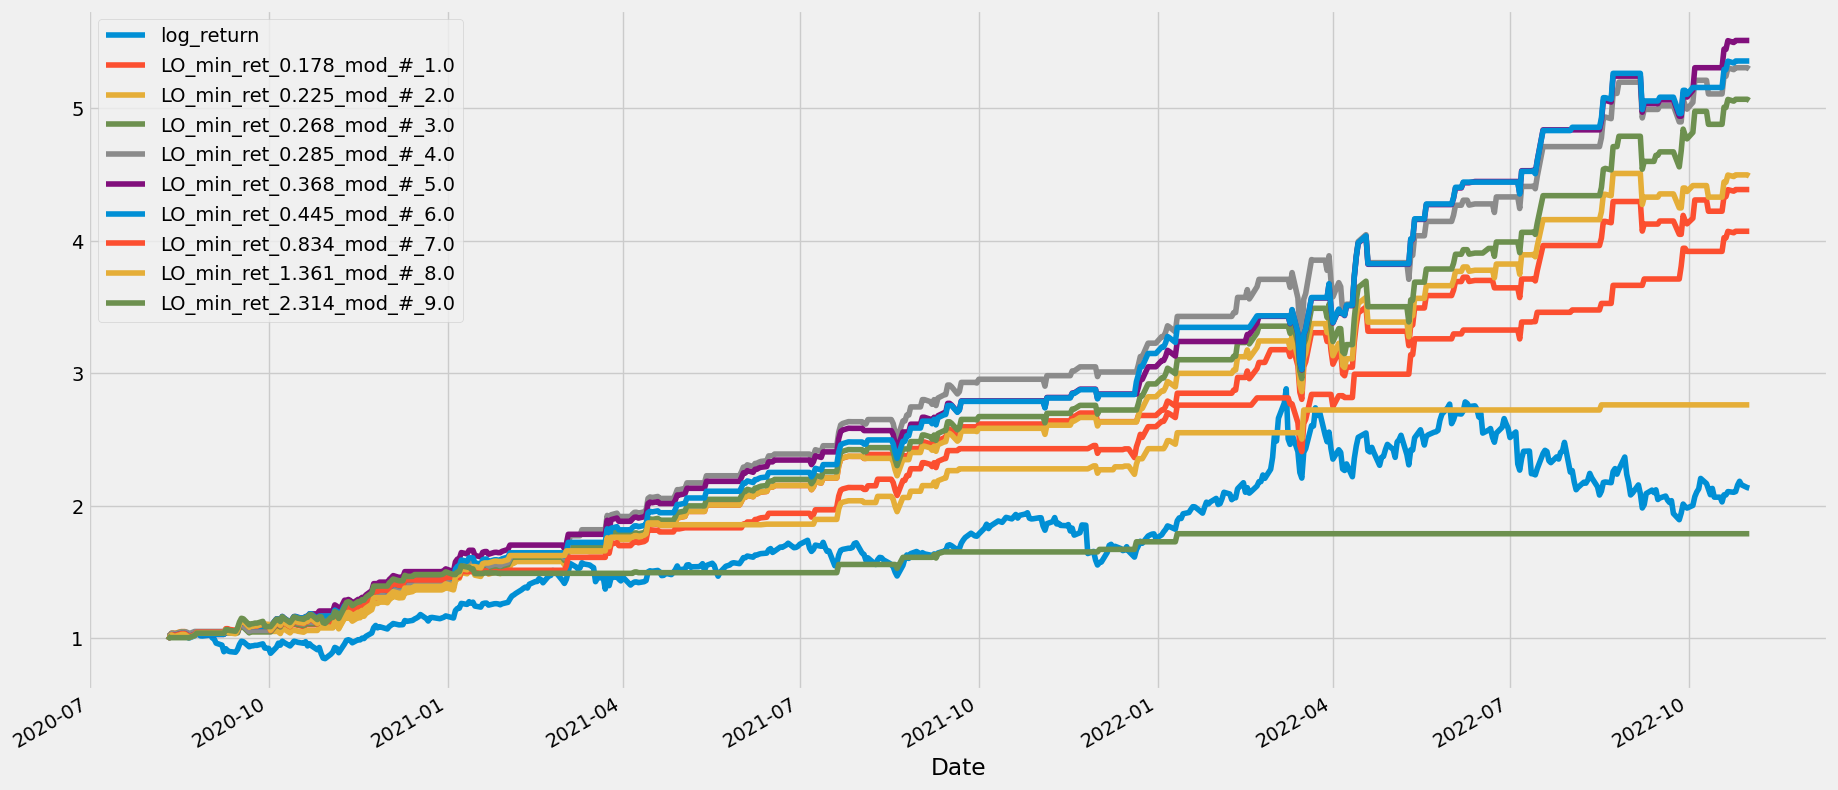

In [31]:
df1[to_plot_LO].cumsum().apply(np.exp).plot()

In [32]:
# Final return
df1[to_plot_LO].cumsum().apply(np.exp).tail(1).T

Date,2022-11-01
log_return,2.131757
LO_min_ret_0.178_mod_#_1.0,4.387571
LO_min_ret_0.225_mod_#_2.0,4.489729
LO_min_ret_0.268_mod_#_3.0,5.059947
LO_min_ret_0.285_mod_#_4.0,5.298038
LO_min_ret_0.368_mod_#_5.0,5.513815
LO_min_ret_0.445_mod_#_6.0,5.358729
LO_min_ret_0.834_mod_#_7.0,4.072449
LO_min_ret_1.361_mod_#_8.0,2.760942
LO_min_ret_2.314_mod_#_9.0,1.787447


### Best result of Phase A

In [33]:
results.tail(10)

,ROC_AUC,Sharpe_LS,Sharpe_LO
mod_num,,,
1,0.615897,1.391868,2.900472
2,0.611782,1.409781,2.919336
3,0.608057,1.664199,3.097142
4,0.610276,1.607895,3.167301
5,0.603065,1.801552,3.365362
6,0.593477,1.803835,3.288678
7,0.582963,1.348928,3.037488
8,0.570178,0.863943,2.585626
9,0.532926,0.334659,1.888666


<AxesSubplot: xlabel='mod_num'>

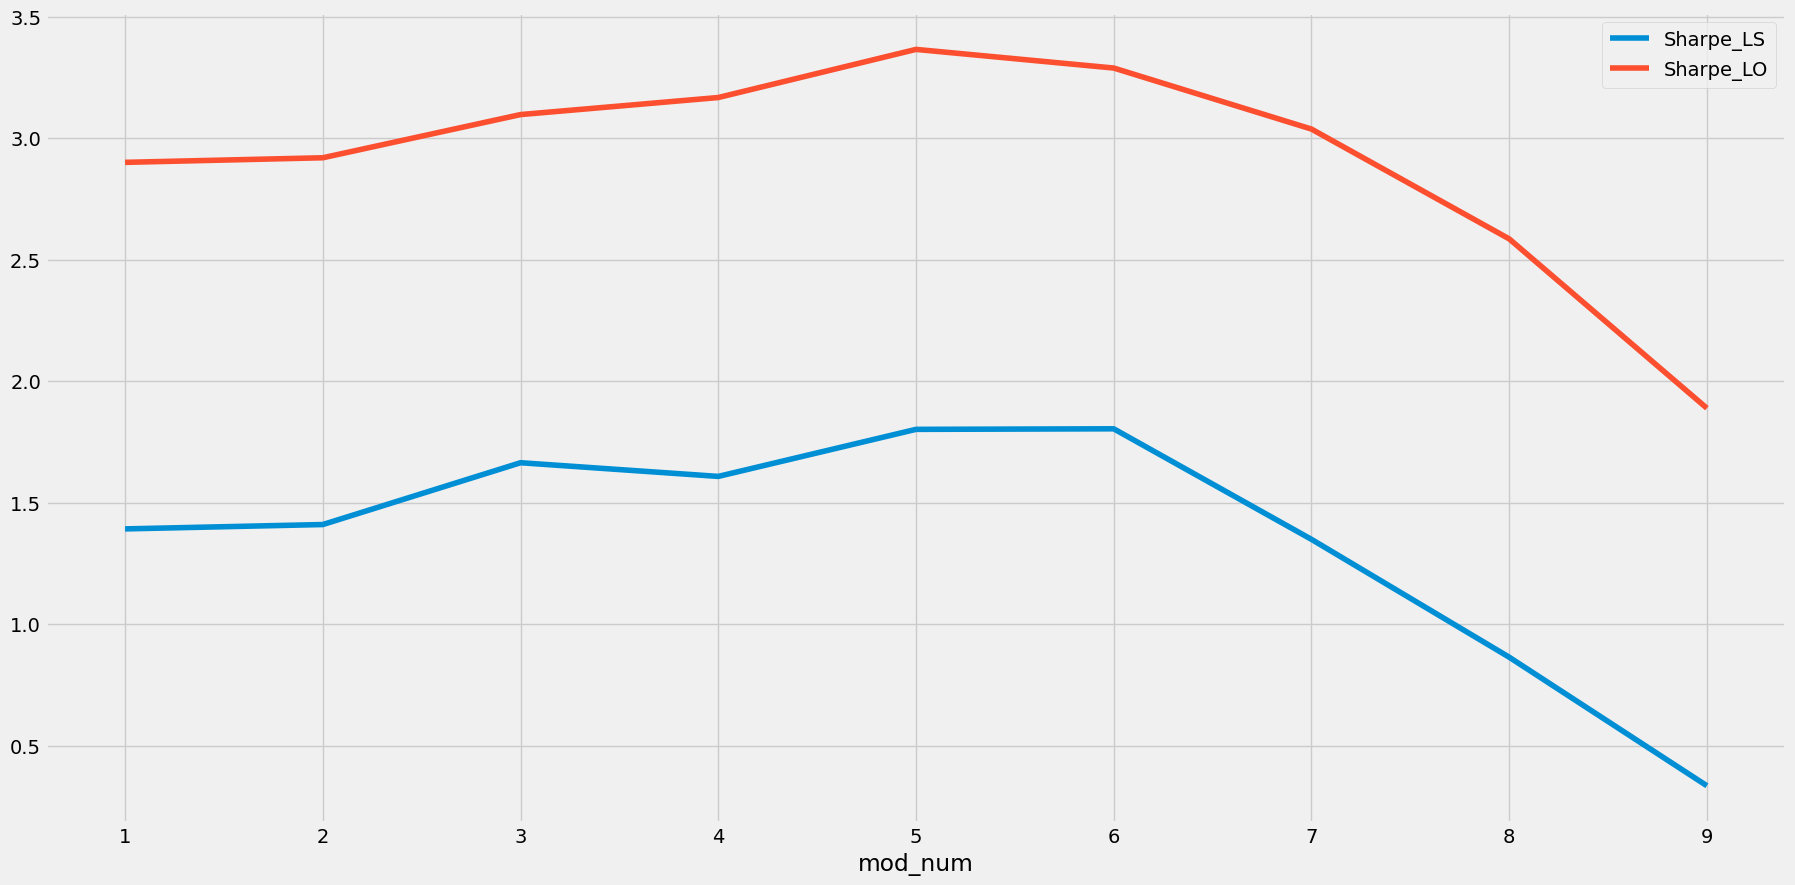

In [34]:
results[['Sharpe_LS', 'Sharpe_LO']].plot()

<AxesSubplot: xlabel='mod_num'>

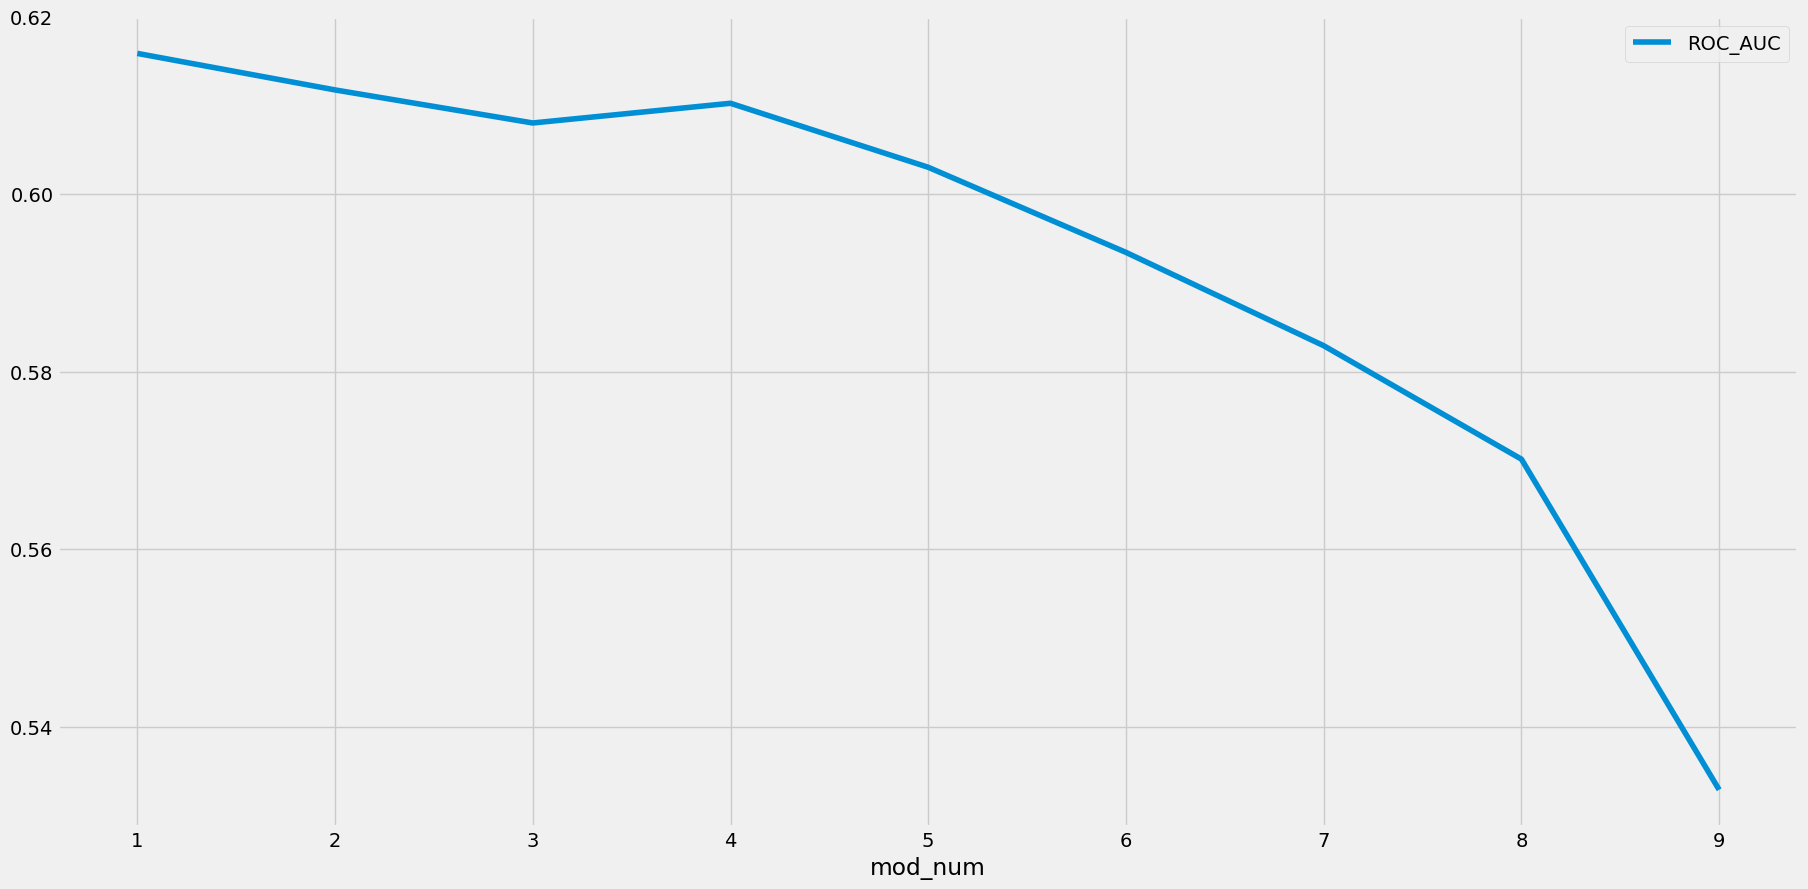

In [35]:
results[['ROC_AUC']].plot()

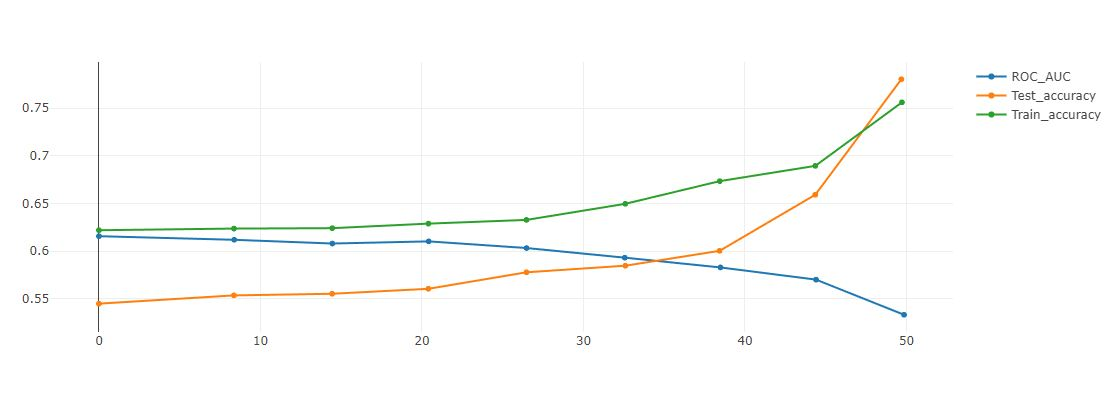

Observation: The long-short strategy underperforms the long-only strategy in this phase. Model \#1 has the highest AUC however does not have the highest Sharpe ratio. Model \#5 has the highest Sharpe ratio and would be our preferred choice at this stage. Using MLFlow to track train and test errors and AUC metrics for our 9 models, we see that as $\tau$ gets larger accuracies increase as well but that is misleading because in fact Class 1 cardinality goes down.

## Phase B: Hyper-parameter tuning

Since hyper-parameter tuning is expensive in time and computing resource, we drop models 5, 6, 7 and focus on tuning models 1-6 through a random cross-validation search.

In [36]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=6, gap=1)

In [37]:
# Hyper parameter optimization
param_grid = {'classifier__C': [1, 10, 100],
              'classifier__gamma': [1, 0.1, 0.01],
              'classifier__kernel': ['rbf','sigmoid'] }

### Main loop for hyperparameter tuning

In [38]:
df2 = df[-len(y_test):]

In [39]:
#Long/Short Strategies
to_plot_LS = ['log_return']
Sharpe_LS = []

#Long-only Strategies
to_plot_LO = ['log_return']
Sharpe_LO = []

model_num = 0

arr_LS = np.empty([6,2], dtype = float)
arr_LO = np.empty([6,2], dtype = float)

for tau in [0.525, 0.535, 0.545, 0.55, 0.575, 0.6]:
    model_num +=1
    print('model number: ', model_num)
    print('tau is:', tau)
    y = np.where((df['return']) >= np.quantile((df['return']), q = tau ), 1, 0)
    min_ret = 100*np.quantile((df['return']), q = tau)
    print("Looking for returns above: ", min_ret)
    mlflow.log_metric("Class_1_min_ret_perc", 100*np.quantile((df['return']), q = tau))
    
    print(pd.Series(y).value_counts())
    class_0, class_1 = np.bincount(y)
    w_0 = 0.5*(1/class_0)*len(y)
    w_1 = 0.5*(1/class_1)*len(y)
    print("Class weights: ", w_0, w_1)
    class_weights = {0: w_0, 1: w_1}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    pipe = Pipeline([("scaler", MinMaxScaler()), 
                 ("pca", PCA(random_state = 12,
                            n_components = 'mle',
                            svd_solver = 'full')),
                 ("classifier", SVC(kernel = 'rbf',
                                    C = 10,
                                    gamma = 0.1,
                                    probability = True,
                                    class_weight = class_weights))
                ]) 
    
    # Random search CV
    rs = RandomizedSearchCV(pipe, param_grid, n_iter=200, scoring='f1', cv=tscv)
    rs.fit(X_train, y_train)
    y_pred = rs.predict(X_test) 
    print("Best parameters: ", rs.best_params_)
    
    probs = rs.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print(f'AUC: {roc_auc:0.4}')
    mlflow.log_metric("ROC_AUC_H", roc_auc)
    arr_LS[model_num-1][0] = roc_auc
    arr_LO[model_num-1][0] = roc_auc
    
    acc_train = accuracy_score(y_train, rs.predict(X_train))
    acc_test = accuracy_score(y_test, y_pred)
    
    mlflow.log_metric("Train_accuracy_H", acc_train)
    mlflow.log_metric("Test_accuracy_H", acc_test)
    mlflow.sklearn.log_model(pipe, "hyper_model")
    
    str1 = ('min_ret_%.3f' % min_ret)
    str2 = ('_mod_#_%.1f' % model_num)
    mod_name = str1+str2
    label_LS = 'L-S_'+mod_name
    df2[label_LS] = df2['log_return'] * y_pred + df2['log_return'] * (1-y_pred) * df2['return_sign_1d']
    to_plot_LS.append(label_LS)
    label_LS_sharpe = label_LS+'_Sharpe'   
    sharpe  = (252**0.5) * df2[label_LS].mean() / df2[label_LS].std()
    arr_LS[model_num-1][1] = sharpe 
    print("Sharpe: ", (252**0.5) * df2[label_LS].mean() / df2[label_LS].std())
    
    label_LO = 'LO_'+mod_name
    df2[label_LO] = df2['log_return'] * y_pred 
    to_plot_LO.append(label_LO)   
    label_LO_sharpe = label_LO+'_Sharpe'    
    sharpe = (252**0.5) * df2[label_LO].mean() / df2[label_LO].std()
    arr_LO[model_num-1][1] = sharpe 
    
    print('----------------')

model number:  1
tau is: 0.525
Looking for returns above:  0.17834915194164758
0    1517
1    1373
dtype: int64
Class weights:  0.9525379037574159 1.0524399126001458
Best parameters:  {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 10}
AUC: 0.6159
Sharpe:  1.3918684707055882
----------------
model number:  2
tau is: 0.535
Looking for returns above:  0.22478124242179906
0    1546
1    1344
dtype: int64
Class weights:  0.9346701164294956 1.0751488095238095
Best parameters:  {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 10}
AUC: 0.6117
Sharpe:  1.4097810649598497
----------------
model number:  3
tau is: 0.545
Looking for returns above:  0.2684968265236314
0    1575
1    1315
dtype: int64
Class weights:  0.9174603174603174 1.0988593155893536
Best parameters:  {'classifier__kernel': 'rbf', 'classifier__gamma': 0.1, 'classifier__C': 10}
AUC: 0.608
Sharpe:  1.6641991813811785
----------------
model number:  4
tau is: 0.55
Looking for return

In [40]:
results_B = pd.DataFrame({'ROC_AUC': arr_LS[:,0], 'Sharpe_LS': arr_LS[:,1], 'Sharpe_LO': arr_LO[:,1]})
results_B.index = range(1,len(results_B)+1)
results_B.index.rename('mod_num', inplace = True)
results_B.tail(10)

,ROC_AUC,Sharpe_LS,Sharpe_LO
mod_num,,,
1,0.615921,1.391868,2.900472
2,0.611734,1.409781,2.919336
3,0.608045,1.664199,3.097142
4,0.610127,1.607895,3.167301
5,0.603077,1.801552,3.365362
6,0.593213,1.803835,3.288678


### Scenario results of Long-short strategy

<AxesSubplot: xlabel='Date'>

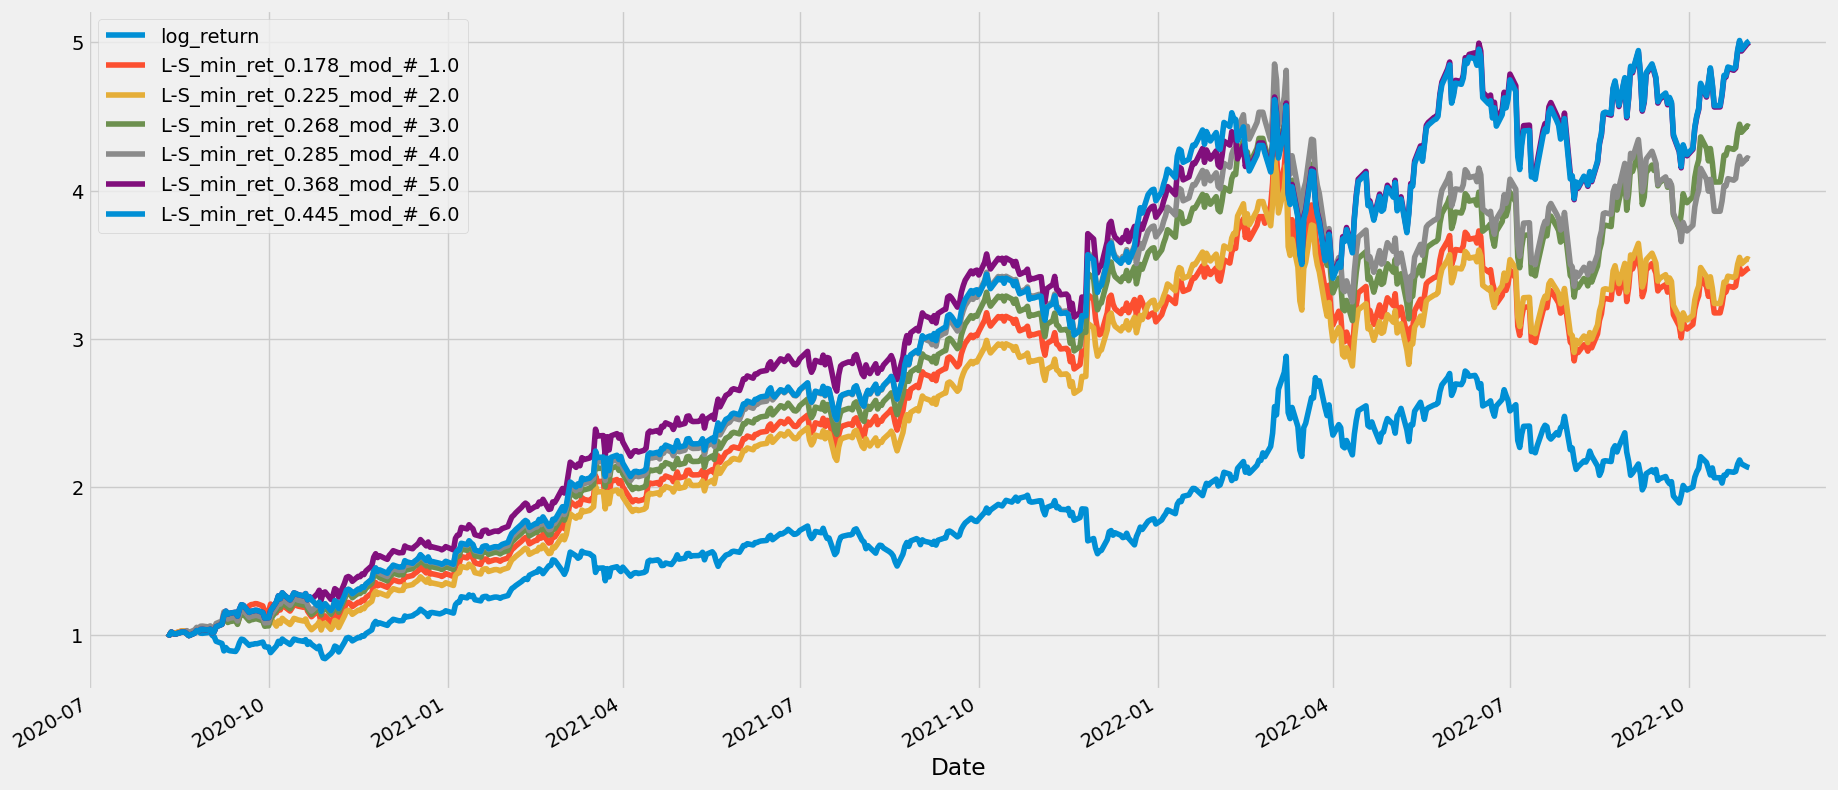

In [41]:
df2[to_plot_LS].cumsum().apply(np.exp).plot()

In [42]:
df2[to_plot_LS].cumsum().apply(np.exp).tail(1).T

Date,2022-11-01
log_return,2.131757
L-S_min_ret_0.178_mod_#_1.0,3.478266
L-S_min_ret_0.225_mod_#_2.0,3.534073
L-S_min_ret_0.268_mod_#_3.0,4.428177
L-S_min_ret_0.285_mod_#_4.0,4.212966
L-S_min_ret_0.368_mod_#_5.0,4.999271
L-S_min_ret_0.445_mod_#_6.0,5.009345


### Scenario results of Long-only strategy

<AxesSubplot: xlabel='Date'>

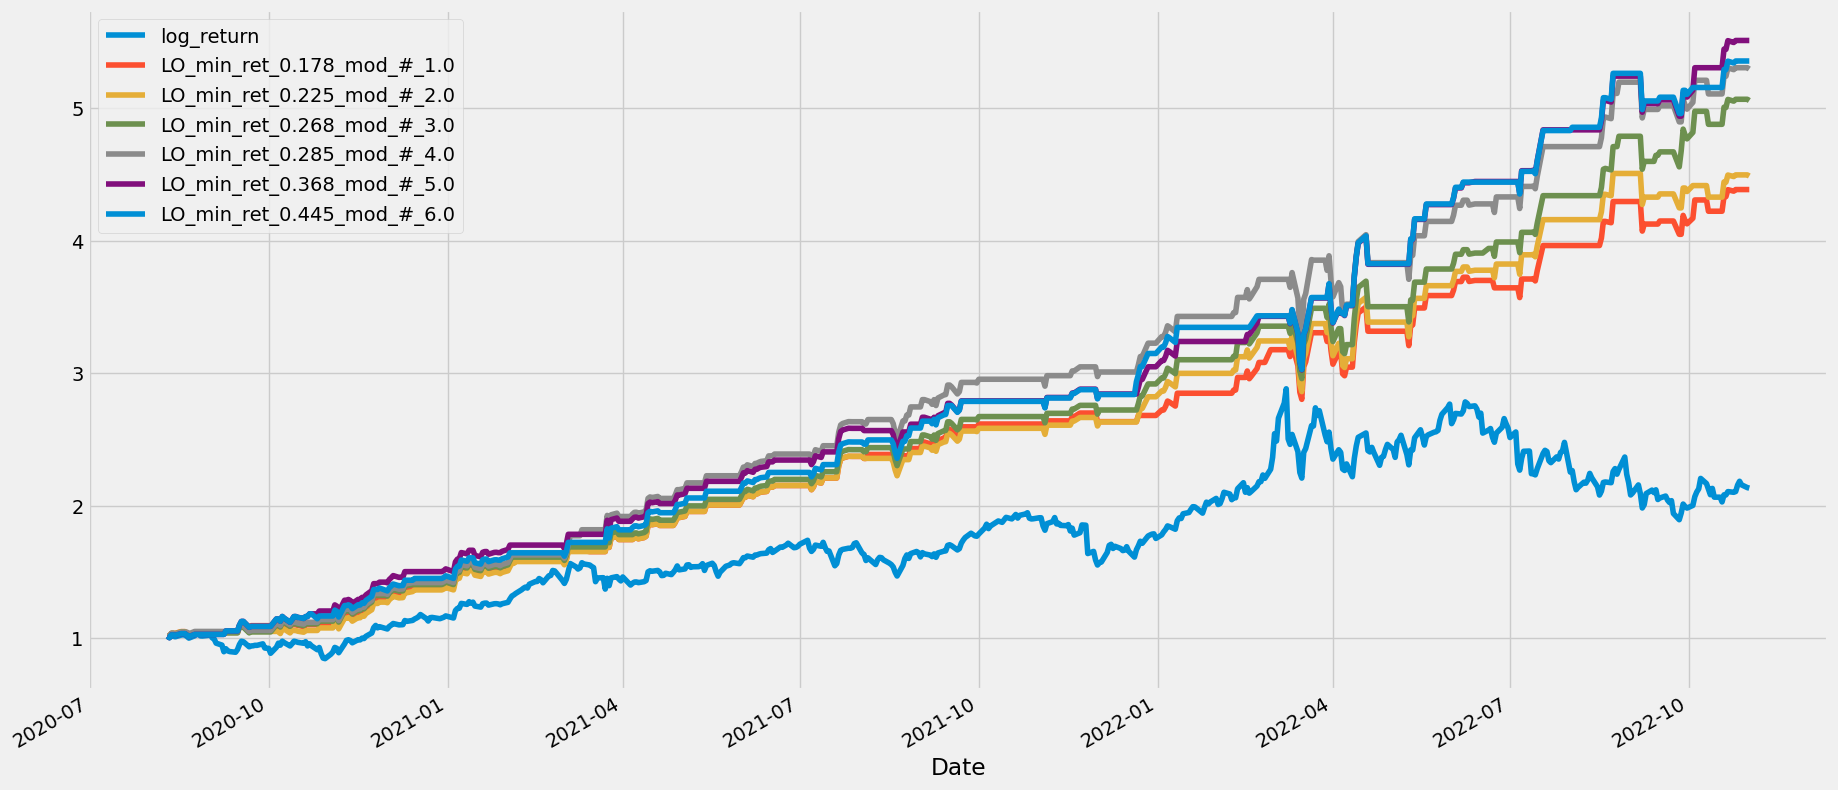

In [43]:
df2[to_plot_LO].cumsum().apply(np.exp).plot()

In [44]:
df2[to_plot_LO].cumsum().apply(np.exp).tail(1).T

Date,2022-11-01
log_return,2.131757
LO_min_ret_0.178_mod_#_1.0,4.387571
LO_min_ret_0.225_mod_#_2.0,4.489729
LO_min_ret_0.268_mod_#_3.0,5.059947
LO_min_ret_0.285_mod_#_4.0,5.298038
LO_min_ret_0.368_mod_#_5.0,5.513815
LO_min_ret_0.445_mod_#_6.0,5.358729


### Best result of Phase B

In [45]:
results_B.tail(10)

,ROC_AUC,Sharpe_LS,Sharpe_LO
mod_num,,,
1,0.615921,1.391868,2.900472
2,0.611734,1.409781,2.919336
3,0.608045,1.664199,3.097142
4,0.610127,1.607895,3.167301
5,0.603077,1.801552,3.365362
6,0.593213,1.803835,3.288678


<AxesSubplot: xlabel='mod_num'>

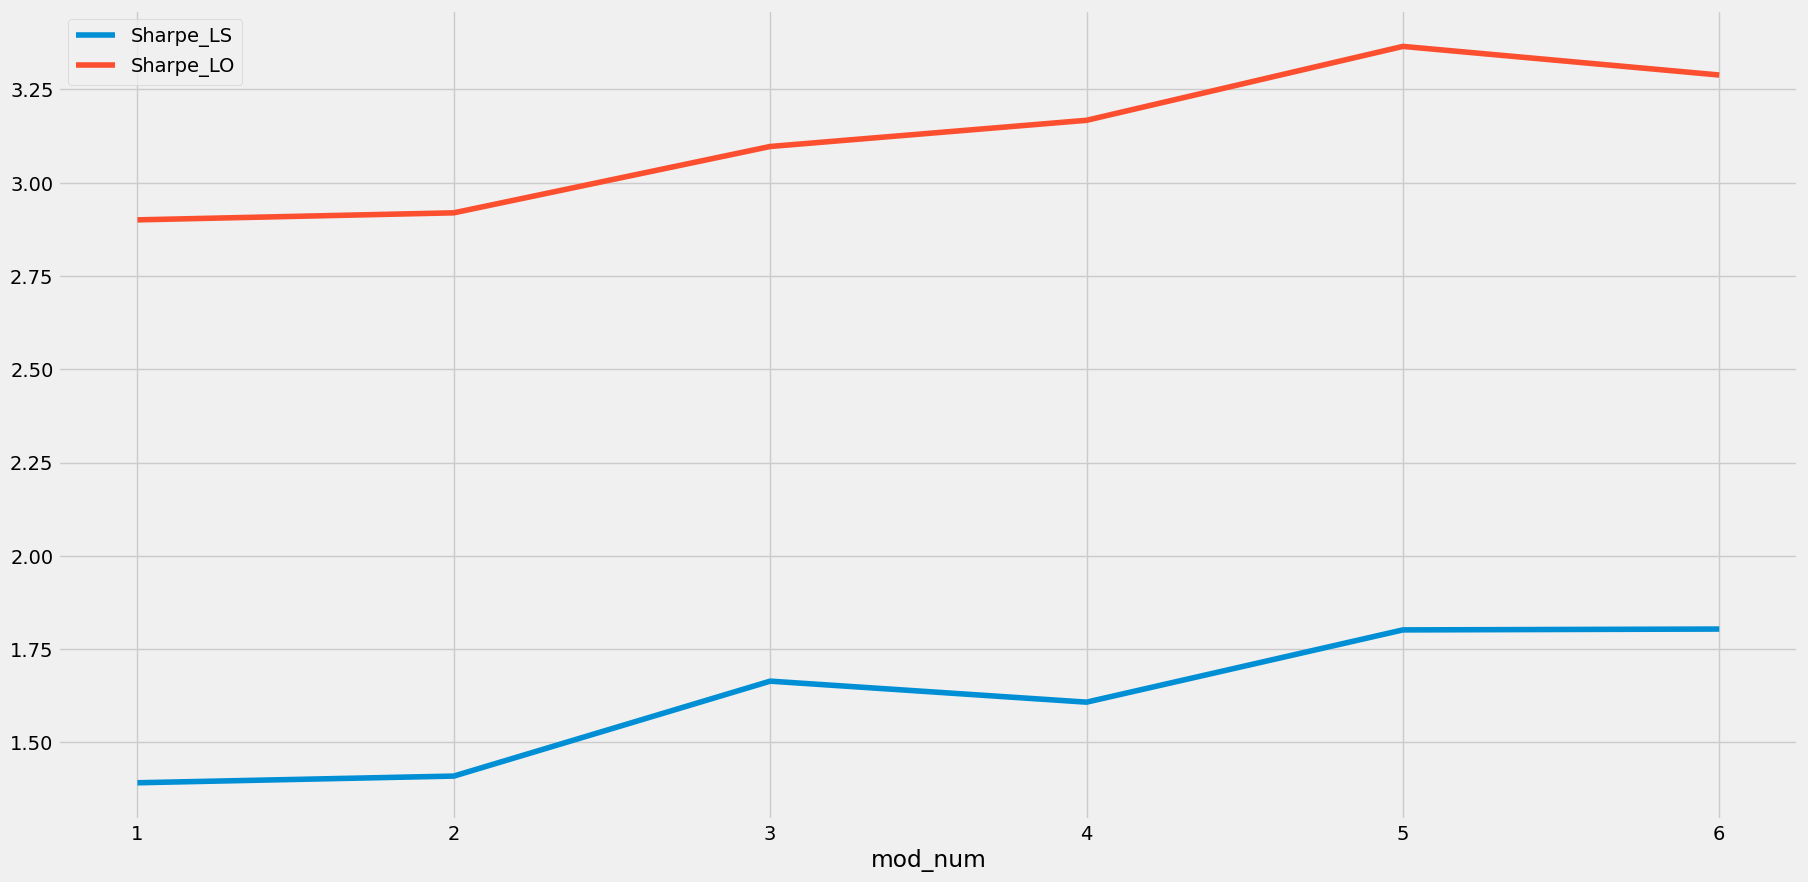

In [46]:
results_B[['Sharpe_LS', 'Sharpe_LO']].plot()

<AxesSubplot: xlabel='mod_num'>

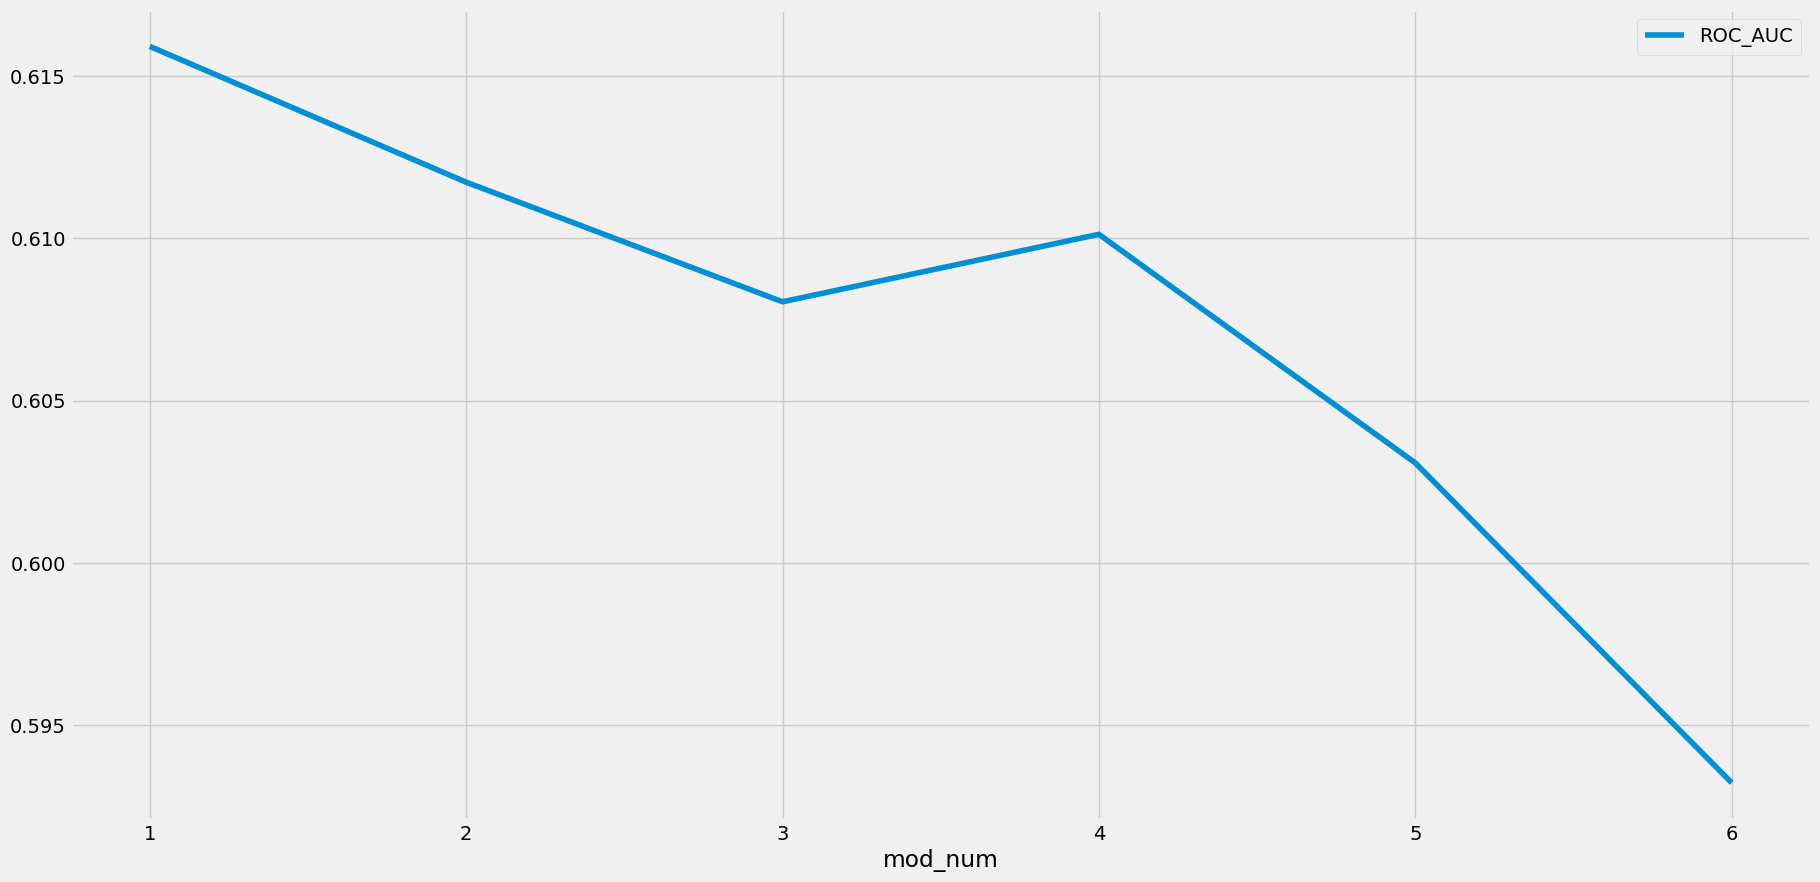

In [47]:
results_B[['ROC_AUC']].plot()

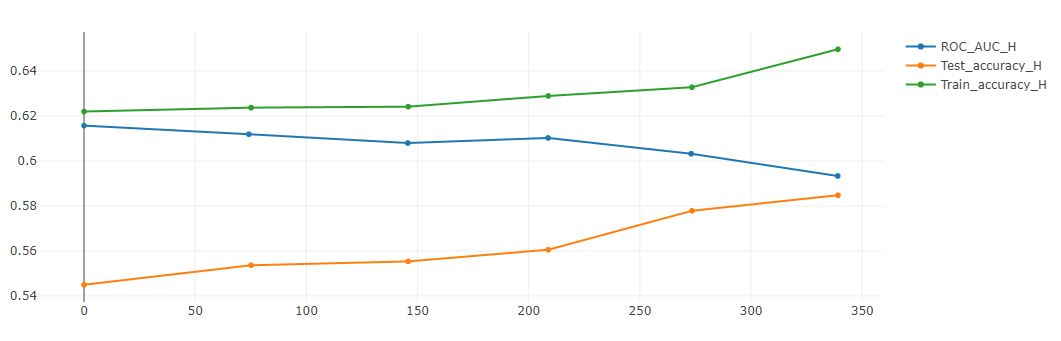

Observation: the hyperparameter tuning seems to converge towards a model with a RBF kernel and where $C$ = 10 and $\gamma = 0.1$. The AUC in the tuning (Stage B) may be lower than in Stage A because cross-validation may be negatively affected by class imbalance (also because we introduce a gap). The best model seems to be model \#5 (hunting for returns above 0.36%), which has an AUC of 0.60 and a Sharpe ratio of 3.36 with a long-only strategy. Looking at the confusion matrix below, FPs are fewer than FNs, but note that because $\tau$ is quite high Class 0 may include quite a few positive returns so FPs may be in fact profitable bets, resulting in model \#5 being the overall winner. Looking at the MLFlow chart, model \#5 seems to have the smallest gap between train accuracy and test accuracy perhaps indicating the smallest model overfit among all models and hence representing the winning strategy.  

In [48]:
# Best Model
tau = 0.575
y = np.where((df['return']) >= np.quantile((df['return']), q = tau ), 1, 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
pipe = Pipeline([("scaler", MinMaxScaler()), 
                 ("pca", PCA(random_state = 12,
                            n_components = 'mle',
                            svd_solver = 'full')),
                 ("classifier", SVC(kernel = 'rbf',
                                    C = 10,
                                    gamma = 0.1,
                                    probability = True,
                                    class_weight = class_weights))
                ]) 
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [49]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       290
           1       0.58      0.55      0.56       288

    accuracy                           0.58       578
   macro avg       0.58      0.58      0.58       578
weighted avg       0.58      0.58      0.58       578



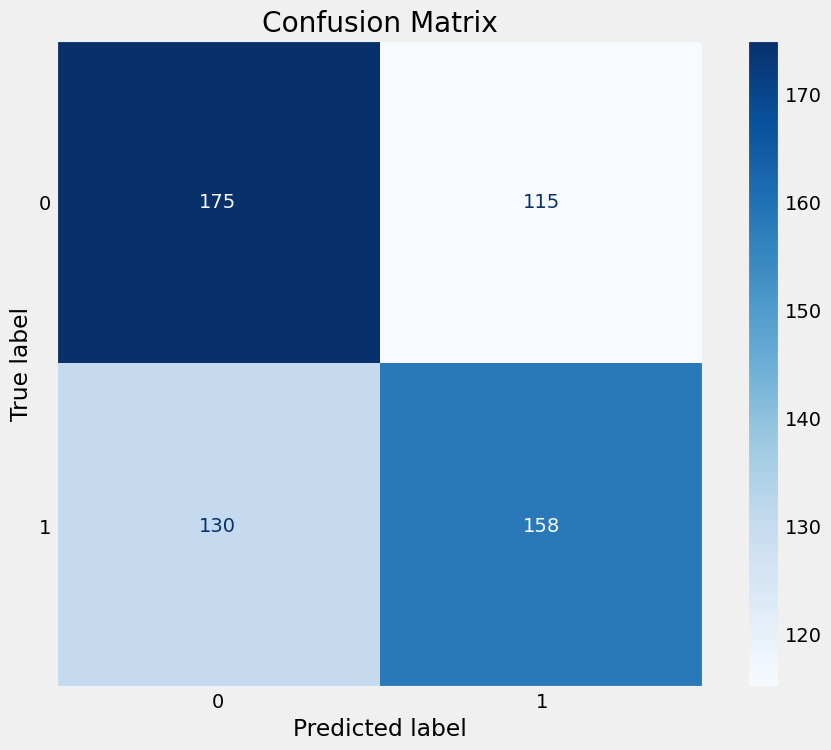

In [50]:
# Confusion matrix
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(pipe, X_test, y_test, ax=ax, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

## Conclusion

Our main observations are:
<ol>
    <li>Labeling is a design choice. Using a parameter $\tau>0$ we label our data per increasing quantile threshold and search for a high-quality classifier looking at a classification metric (AUC) and financial metric (Sharpe ratio). We narrow our search to a smaller subset of thresholds to conduct a tuning of hyperparameters. We land on a model with a RBF kernel and $C=10$, $\gamma=0.1$ and $\tau=0.575$ i.e. hunting for returns above 0.36%, which is fairly aggressive in my experience, with AUC = 0.60 and Sharpe = 3.36.  We should not expect such results in real-life however, due to slippage, risk management, etc. It should give us a terminal position on the equity curve of 5.51, way above a passive-long investment in the ticker (terminal position of 2.13). Looking at the MLFlow chart, model \#5 seems to have the smallest gap between train accuracy and test accuracy perhaps indicating the smallest model overfit among all models and hence representing the winning strategy.  
        <li>For this ticker and choice of classification procedure, long-only strategies overperform long-short strategies.
            <li>Cross-validation may results in lower performance due to class imbalance and the introduction of a gap in times series split.

Directions of future research include:
<ol>
    <li>Using volume or dollar bars as recommended in Reference 2. Additionally, p. 44 of Reference 2 specifies: "it is a very common error to label observations according to a fixed [return] threshold on time bars"; instead the author recommends the triple barrier method as it better encapsulates risk management practices. We leave this as future research. We attempted adding a volatility filter on our labels and it did not improve either classification or financial performance.
        <li> Using combinatorial purged cross-validation technique for backtesting as recommended in References 2 and 3.
        <li> Testing other approaches to class imbalances such as over/undersampling via the imbalanced-learn library.
            <li> Investigating other features including different windows defining technical indocators.

## References

1- The Elements of Statistical Learning, Second Edition, Hastie, Tibshirani, Friedman, 2017

2- Advances in Financial Machine Learning, Lopez de Prado, 2018

3- https://blog.quantinsti.com/cross-validation-embargo-purging-combinatorial/

4- Python Technical Analysis library https://technical-analysis-library-in-python.readthedocs.io/en/latest/

5- Using volume weighted Support Vector Machines with walk forward testing and feature selection for the purpose of creating stock trading strategy, Expert systems with applications, 2015

6- Automatic choice of dimensionality for PCA, Minka, 2000